This notebook contains all code necessary to run the experiments and produce the graphs in the paper "Conditional and Modal Reasoning in Large Language Models" (https://arxiv.org/abs/2401.17169) by Wesley H. Holliday (wesholliday@berkeley.edu), Matthew Mandelkern (mandelkern@nyu.edu), and Cedegao E. Zhang (cedzhang@mit.edu).

The notebook was created using Python 3.11.6 and Seaborn 0.12.0.

To collect responses from one of the open-weight LLMs, use LM Studio (https://lmstudio.ai), v0.2.11 or later, to set up a local inference server with base_url=http://localhost:1234/v1.

In [1]:
from openai import OpenAI
import anthropic
import google.generativeai as genai
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tickerim
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import os
import re
import numpy as np
from tqdm.notebook import tqdm
import time
import scipy.stats as stats
from itertools import permutations

In [2]:
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

ANTHROPIC_API_KEY = os.getenv('ANTHROPIC_API_KEY')

GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# Outline

### 1. Setup

### 2. Collect model response data

### 3. Create dataframe

### 4. Create figures for paper

- 4.1 Figure 1: performance summary
- 4.2 Figure 5: correlations with LMSYS, MMLU, and GSM8K
- 4.3 Table 2: deltas with few-shot and chain-of-thought
- 4.4 Figures with green bars: average frequency of correct answer
- 4.5 Figures with orange bars: average frequency of 'no' and average frequency of 'yes'
- 4.6 Figure 3: consistency on DSmu, DSmi, and MiN

### 5. Supplementary material

- 5.1 Queries and errors per model

- 5.2 Correlations for sensical vs. non-sensical predicates

- 5.3 Correlations between different question wordings

- 5.4 Log probs

# 1. Setup

### Models

In [3]:
model_dict ={0: ("claude_3_haiku_20240307", "Claude 3 Haiku", "claude-3-haiku-20240307", "claude-3-haiku-20240307"),
             1: ("claude_3_sonnet_20240229", "Claude 3 Sonnet", "claude-3-sonnet-20240229", "claude-3-sonnet-20240229"),
             #2: ("claude_3_5_sonnet_20240620", "Claude 3.5 Sonnet", "claude-3-5-sonnet-20240620", None), # released after submission deadline
             3: ("claude_3_opus_20240229", "Claude 3 Opus", "claude-3-opus-20240229", "claude-3-opus-20240229"),
             4: ("code_llama_7B", "Code Llama 7B", "code llama instruct 7B Q6_K gguf", None),
             5: ("code_llama_13B", "Code Llama 13B", "code llama instruct 13B Q6_K gguf", None),
             6: ("code_llama_34B", "Code Llama 34B", "code llama instruct 34B Q6_K gguf", "codellama-34b-instruct"),
             7: ("gemini_1-5_flash", "Gemini 1.5 Flash", "gemini-1.5-flash", "gemini-1.5-flash-api-0514"),
             8: ("gemini_1-5_pro", "Gemini 1.5 Pro", "gemini-1.5-pro", "gemini-1.5-pro-api-0514"),
             9: ("gpt_3_5_turbo_0613", "GPT-3.5 Turbo (0613)", "gpt-3.5-turbo-0613", "gpt-3.5-turbo-0613"), 
             10: ("gpt_3_5_turbo_1106", "GPT-3.5 Turbo (1106)", "gpt-3.5-turbo-1106", "gpt-3.5-turbo-1106"),    
             11: ("gpt_3_5_turbo_0125", "GPT-3.5 Turbo (0125)" , "gpt-3.5-turbo-0125", "gpt-3.5-turbo-0125"),   
             12: ("gpt_4_0314", "GPT-4 (0314)", "gpt-4-0314", None), 
             13: ("gpt_4_0613", "GPT-4 (0613)", "gpt-4-0613", "gpt-4-0613"),
             14: ("gpt_4_turbo_1106", "GPT-4 Turbo (1106)", "gpt-4-1106-preview", "gpt-4-1106-preview"), 
             15: ("gpt_4_turbo_2024_04_09", "GPT-4 Turbo (2024-04-09)", "gpt-4-turbo-2024-04-09", "gpt-4-turbo-2024-04-09"),
             16: ("gpt_4o_2024_05_13", "GPT-4o (2024-05-13)" , "gpt-4o-2024-05-13", "gpt-4o-2024-05-13"),
             17: ("llama_2_chat_7B", "Llama 2 Chat 7B", "llama 2 chat 7B Q6_K gguf", "llama-2-7b-chat"),
             18: ("llama_2_chat_13B", "Llama 2 Chat 13B", "llama 2 chat 13B Q6_K gguf", "llama-2-13b-chat"), 
             19: ("llama_2_chat_70B", "Llama 2 Chat 70B", "llama 2 chat 70B Q6_K gguf", "llama-2-70b-chat"),
             20: ("llama_3_instruct_8B", "Llama 3 Instruct 8B", "llama 3 instruct 8B Q6_K gguf", "llama-3-8b-instruct"),
             21: ("llama_3_instruct_70B", "Llama 3 Instruct 70B", "llama 3 instruct 70B Q6_K gguf", "llama-3-70b-instruct"),
             22: ("mistral_instruct", "Mistral 7B", "mistral instruct v0 2 7B Q6_K gguf", "mistral-7b-instruct-v0.2"), 
             23: ("mixtral_instruct", "Mixtral 8x7B", "mixtral 8x instruct v0 1 7B Q6_K gguf", "mixtral-8x7b-instruct-v0.1"), 
             24: ("phi_2", "Phi-2", "phi 2 3B Q6_K gguf", None), 
             25: ("yi_chat_34B", "Yi Chat 34B", "yi chat 34B Q6_K gguf", "yi-34b-chat"),          
}

local_models = [4,5,6,17,18,19,20,21,22,23,24,25]
non_local_models = [n for n in range(26) if n not in local_models]

anthropic_models = [0,1,2,3]
google_models = [7,8]
open_ai_models = [9,10,11,12,13,14,15,16]

### Select a model to test

In [4]:
model_nums = [0] # These are the models that will be used in Section 2

print([model_dict[model_num][0] for model_num in model_nums])

if len(model_nums) > 1 and any([n for n in model_nums if n in local_models]):
    print("Error: only one local model can be run at once.")
    model_nums = None

['claude_3_haiku_20240307']


### Select condition

In [5]:
condition = 'zero-shot' # 'few-shot' or 'zero-shot' or 'chain_of_thought'

In [6]:
if condition == 'zero-shot':
    system_prompt = "Answer only with 'yes' or 'no' and nothing else."
    max_tokens = 8

if condition == 'few-shot':
    system_prompt = """Consider the following examples:

From 'Ann went to the store', can we infer that 'Ann went to the store and Bob went to the beach'? Correct answer: No.

From 'Ann went to the store', can we infer that 'Ann went to the store or Bob went to the beach'? Correct answer: Yes.

From 'Ann went to the store and Bob went to the beach', can we infer that 'Ann went to the store'? Correct answer: Yes.

From 'Ann went to the store or Bob went to the beach', can we infer that 'Ann went to the store'? Correct answer: No.

Now here is a question for you, which you should answer with only 'yes' or 'no' and nothing else: """

    max_tokens = 8

if condition == 'chain_of_thought':
    system_prompt = "In response to the following question, think step by step and explain your reasoning, starting your response with 'Explanation: '; then *after* explaining your reasoning, when you are ready to answer, simply write 'Answer: ' followed by 'yes' or 'no' and nothing else. Please make sure to format your response by first explaining your reasoning and then writing 'Answer:' followed by 'yes' or 'no' at the very end."
    
    #For some small models, we had to emphasize that they should think first and answer second:
    
    #"In response to the following question, think step by step and explain your reasoning; then *after* explaining your reasoning, when you are ready to answer, simply write 'Answer: ' followed by 'yes' or 'no' and nothing else. Make sure not to answer with 'Answer:' until *after* you think step by step and explain your reasoning."

    #"In response to the following question, think step by step and explain your reasoning, starting your response with 'Explanation: '; then *after* explaining your reasoning, when you are ready to answer, simply write 'Answer: ' followed by 'yes' or 'no' and nothing else. Please make sure to format your response by first explaining your reasoning and then writing 'Answer:' followed by 'yes' or 'no' at the very end."
    
    max_tokens = 1024

### Select prompts

In [7]:
selected_prompt_classes = ['MT','MTx','uMT','vMT','MTo','MTox', # versions of Modus Tollens
                           'MP','MPx','uMP','vMP','MPo','MPox', # versions of Modus Ponens

                           'AC','ACx','uAC','vAC','ACo','ACox', # versions of Affirming the Consequent
                           'LAC','cAC','LcAC','dAC','LdAC','sAC','snAC','gAC','gnAC', # more versions of Affirming the Consequent with altered phrasing
                           'CONV','CONVx','uCONV','vCONV', # versions of Conversion

                           'DA','DAx','uDA','vDA','DAo','DAox', # versions of Denying the Antecedent
                           'INV','INVx','uINV','vINV', # versions of Inversion

                           'DS','DSx','uDS','vDS','DSo','DSox','DSf','DSfx','DSfo','DSfox', # versions of Disjunctive Syllogism   
                           
                           'CT','CTx','CTn','CTnx','CTnd','uCTnd','vCTnd', # versions of Contraposition
                           'ASd','ASx','uASd','vASd', # versions of Antecedent Strengthening

                           'MiN','MiNx','uMiN','vMiN','NMu','NMux','uNMu','vNMu', # versions of Duality inferences 

                           'MTmu','MTmux','uMTmu','vMTmu','MTmuo','MTmuox', # versions of Modus Tollens Must
                           'MTmi','MTmix','uMTmi','vMTmi','MTmio','MTmiox', # versions of Modus Tollens Might

                           'DSmu','DSmux','uDSmu','vDSmu','DSmuo','DSmuox','DSmuf','DSmufx','DSmufo','DSmufox', # versions of Disjunctive Syllogism Must
                           'DSmi','DSmix','uDSmi','vDSmi','DSmio','DSmiox','DSmif','DSmifx','DSmifo','DSmifox', # versions of Disjunctive Syllogism Might

                           'CMP', 'CMPx' # complex Modus Ponens
]

user_prompts = list()
prompt_classes = list()

for file in os.listdir('prompts'):
    if file.endswith('.json'):
        prompt_class = file[:-5]
        if prompt_class in selected_prompt_classes:
            prompt_classes.append(file[:-5])
            with open('prompts/' + file) as f:
                user_prompts += json.load(f)
        else:
            print('Skipping', file[:-5])

print(sorted(prompt_classes))

Skipping MiN_match
Skipping NMu_match
['AC', 'ACo', 'ACox', 'ACx', 'ASd', 'ASx', 'CMP', 'CMPx', 'CONV', 'CONVx', 'CT', 'CTn', 'CTnd', 'CTnx', 'CTx', 'DA', 'DAo', 'DAox', 'DAx', 'DS', 'DSf', 'DSfo', 'DSfox', 'DSfx', 'DSmi', 'DSmif', 'DSmifo', 'DSmifox', 'DSmifx', 'DSmio', 'DSmiox', 'DSmix', 'DSmu', 'DSmuf', 'DSmufo', 'DSmufox', 'DSmufx', 'DSmuo', 'DSmuox', 'DSmux', 'DSo', 'DSox', 'DSx', 'INV', 'INVx', 'LAC', 'LcAC', 'LdAC', 'MP', 'MPo', 'MPox', 'MPx', 'MT', 'MTmi', 'MTmio', 'MTmiox', 'MTmix', 'MTmu', 'MTmuo', 'MTmuox', 'MTmux', 'MTo', 'MTox', 'MTx', 'MiN', 'MiNx', 'NMu', 'NMux', 'cAC', 'dAC', 'gAC', 'gnAC', 'sAC', 'snAC', 'uAC', 'uASd', 'uCONV', 'uCTnd', 'uDA', 'uDS', 'uDSmi', 'uDSmu', 'uINV', 'uMP', 'uMT', 'uMTmi', 'uMTmu', 'uMiN', 'uNMu', 'vAC', 'vASd', 'vCONV', 'vCTnd', 'vDA', 'vDS', 'vDSmi', 'vDSmu', 'vINV', 'vMP', 'vMT', 'vMTmi', 'vMTmu', 'vMiN', 'vNMu']


In [8]:
if condition == 'chain_of_thought':
    temperatures = [0]

else:
    temperatures = [0, 1]

num_prompts_per_temp = {0: 1, 1: 20}

### Helper functions

A number of the LLMs often disobey the system prompt to say *nothing else* except 'yes' or 'no'. Thus, we extract 'yes' or 'no' from their response using regular expressions.

In [9]:
def contains_yes(response):
    # Regular expression pattern
    # \b represents a word boundary
    # 'yes' is the word to search
    # [.,;:-]? allows for an optional period, comma, semicolon, colon, or dash after "yes"
    # re.IGNORECASE makes the search case-insensitive
    pattern = r'\byes\b[.,;:-]?'

    # Search for the pattern in the response
    return re.search(pattern, response, re.IGNORECASE) is not None

def contains_no(response):
    # Regular expression pattern
    # \b represents a word boundary
    # 'no' is the word to search
    # [.,;:-]? allows for an optional period, comma, semicolon, colon, or dash after "no"
    # re.IGNORECASE makes the search case-insensitive
    pattern = r'\bno\b[.,;:-]?'

    # Search for the pattern in the response
    return re.search(pattern, response, re.IGNORECASE) is not None


For the chain-of-thought condition, we extract the part of the response after the word 'Answer:' appears.

In [10]:
def after_answer(response):
    pattern = r'(?i)answer:'  # Case-insensitive regex pattern for 'Answer:' or 'answer:'
    try:
        return re.split(pattern, response)[-1]  # Return the part after the last occurrence
    except IndexError:
        return response

# 2. Collect model response data

We are interested in not only whether an LLM operating at zero temperature gives an affirmative answer or negative answer to a logical inference question, but also the frequency with which an LLM operating at temperature 1 gives an affirmative answer or negative answer to a logical inference question. We compare these frequencies to probabilities computed from log probs for the OpenAI models in Section 5.4 below.

In [11]:
get_responses = False # Set to True to get responses from the API. Set to False to just analyze the data that has already been collected.

for model_num in model_nums:

    model_short_name = model_dict[model_num][0]
    model_display_name = model_dict[model_num][1]
    model_full_name = model_dict[model_num][2]
    model_lmsys_name = model_dict[model_num][3]

    if get_responses:
        print("Model:", model_short_name)
        print("Condition:", condition)
        print("")

        for up in tqdm(user_prompts):
            prompt_class, prompt_num, user_prompt = up

            if condition == 'few-shot' and prompt_class in ['CMP', 'CMPx', 'LAC','cAC','LcAC','dAC','LdAC','sAC','snAC','gAC','gnAC']:
                continue

            for temperature in temperatures:

                # if the data file already exists, continue
                if os.path.exists(f'data/{condition}/{model_short_name}/{prompt_class}/{model_short_name}_{prompt_class}_{prompt_num}_{temperature}.json'):
                    continue

                print("Prompt:", user_prompt)
                print("Temperature:", temperature)
                print("")

                data = {
                    "user_prompt": user_prompt,
                    "system_prompt": system_prompt,
                    "model": model_full_name,
                    "temperature": temperature,
                    "responses": []
                }

                for n in range(num_prompts_per_temp[temperature]):

                    if model_short_name in ['gpt_4o_2024_05_13','gpt_4_turbo_2024_04_09', 'gpt_4_turbo_1106', 'gpt_4_0613', 'gpt_4_0314', 'gpt_3_5_turbo_1106', 'gpt_3_5_turbo_0613', 'gpt_3_5_turbo_0125']:
                        
                        client = OpenAI(api_key=OPENAI_API_KEY)
                        completion = client.chat.completions.create(
                        model=model_full_name,
                        messages=[
                                {"role": "system", "content": system_prompt},
                                {"role": "user", "content": user_prompt}],
                        temperature=temperature,
                        max_tokens=max_tokens,
                        )
                        print(completion.choices[0].message)
                        message_json = completion.choices[0].message.model_dump_json()
                        answer = json.loads(message_json)

                    elif model_short_name in ['claude_3_opus_20240229', 'claude_3_sonnet_20240229', 'claude_3_5_sonnet_20240620', 'claude_3_haiku_20240307']:

                        client = anthropic.Anthropic(
                            api_key=ANTHROPIC_API_KEY,
                        )

                        response = client.messages.create(
                            model=model_full_name,
                            max_tokens=max_tokens,
                            temperature=temperature,
                            system=system_prompt,
                            messages=[
                                {"role": "user", "content": user_prompt}
                            ]
                        )
                        text = response.content[0].text
                        print(text)
                        answer = {"content": text}

                    elif model_short_name in ['gemini_1-5_pro', 'gemini_1-5_flash']:

                        model = genai.GenerativeModel(model_full_name)
                        response = model.generate_content(
                            system_prompt + " " + user_prompt,
                            generation_config=genai.types.GenerationConfig(
                                candidate_count=1,
                                max_output_tokens=max_tokens,
                                temperature=temperature)
                        )
                        text = response.text
                        print(text)
                        answer = {"content": text}      
                    
                    else:
                        client = OpenAI(base_url="http://localhost:1234/v1", api_key="not-needed") 
                        completion = client.chat.completions.create(
                        model="local-model",
                        messages=[
                                {"role": "system", "content": system_prompt},
                                {"role": "user", "content": user_prompt}],
                        temperature=temperature,
                        max_tokens=max_tokens,
                        )
                        print(completion.choices[0].message)
                        message_json = completion.choices[0].message.model_dump_json()
                        answer = json.loads(message_json)

                    data["responses"].append(answer)

                    # if all the responses are 'yes' or all response are 'no' by some checkpoint number of iterations, then break
                    if model_short_name in ['claude_3_opus_20240229', 'claude_3_5_sonnet_20240620', 'gemini_1-5_pro', 'gpt_4o_2024_05_13', 'gpt_4_turbo_2024_04_09', 'gpt_4_turbo_1106', 'gpt_4_0613', 'gpt_4_0314']:
                        impatience = 4
                    else:
                        impatience = 2

                    if n == (num_prompts_per_temp[temperature] // impatience) - 1:
                        
                        if condition == "zero-shot" or condition == "few-shot":
                        
                            if all(contains_yes(response) for response in [data["responses"][k]["content"] for k in range(n)]) and not any(contains_no(response) for response in [data["responses"][k]["content"] for k in range(n)]):
                                break
                            elif all(contains_no(response) for response in [data["responses"][k]["content"] for k in range(n)]) and not any(contains_yes(response) for response in [data["responses"][k]["content"] for k in range(n)]):
                                break

                        if condition == "chain_of_thought":
                            if all(contains_yes(after_answer(response)) for response in [data["responses"][k]["content"] for k in range(n)]) and not any(contains_no(response) for response in [data["responses"][k]["content"] for k in range(n)]):
                                break
                            elif all(contains_no(after_answer(response)) for response in [data["responses"][k]["content"] for k in range(n)]) and not any(contains_yes(response) for response in [data["responses"][k]["content"] for k in range(n)]):
                                break

                print("")
                
                # create the appropriate directory if it doesn't already exist
                if not os.path.exists(f'data/{condition}/{model_short_name}/{prompt_class}'):
                    os.makedirs(f'data/{condition}/{model_short_name}/{prompt_class}')

                # Save the data to a JSON file
                with open(f'data/{condition}/{model_short_name}/{prompt_class}/{model_short_name}_{prompt_class}_{prompt_num}_{temperature}.json', 'w') as json_file:
                    json.dump(data, json_file, indent=4)

# 3. Create dataframe

### Additional helper functions

We noticed that models sometimes responded with 'we can' instead of 'yes' and 'we cannot' instead of 'no', so we allow these responses (but flag them below).

In [12]:
def contains_can(response):
    # Regular expression pattern
    # \b represents a word boundary
    # 'can' is the word to search
    # (?!not\b|'t\b| be\b) is a negative lookahead that ensures 'can' is not followed by 'not', 't', or ' be'
    # [.,;:-!]? allows for an optional period, comma, semicolon, colon, or dash after "can"
    # re.IGNORECASE makes the search case-insensitive
    pattern = r'\bcan\b(?!not\b|\'t\b| be\b)[.,;:-]?'

    # Search for the pattern in the response
    return re.search(pattern, response, re.IGNORECASE) is not None

def contains_cannot(response):
    # Regular expression pattern
    # \b represents a word boundary
    # '(?:cannot|can't)' is a non-capturing group that matches either 'cannot' or 'can't'
    # [.,;:-!]? allows for an optional period, comma, semicolon, colon, or dash after "cannot" or "can't"
    # re.IGNORECASE makes the search case-insensitive
    pattern = r'\b(?:cannot|can\'t)\b[.,;:-]?'

    # Search for the pattern in the response
    return re.search(pattern, response, re.IGNORECASE) is not None

print(contains_can("We can infer that"))
print(contains_can("We can't infer that"))
print(contains_can("We cannot infer that"))
print(contains_can("The argument's structure can be represented..."))
print("")
print(contains_cannot("We can infer that"))
print(contains_cannot("We can't infer that"))
print(contains_cannot("We cannot infer that"))
print(contains_cannot("The argument's structure can be represented..."))


True
False
False
False

False
True
True
False


### Process data to create dataframe

In [13]:
verbose = False # Set to True to print out warnings and errors

models_with_prompts_not_finished = list()

df = pd.DataFrame(columns=["prompt_class", "prompt_num", "prompt", "model", "temperature", "yes_count", "no_count", "num_trials", "yes_percent", "no_percent"])

model_display_names = [model_dict[mod][1] for mod in model_dict.keys()]
queries_per_model = {model_display_name: 0 for model_display_name in model_display_names}

error_both_response = {model_display_name: 0 for model_display_name in model_display_names}
error_no_response = {model_display_name: 0 for model_display_name in model_display_names}

can_or_cannot_response = {model_display_name: 0 for model_display_name in model_display_names}
can_and_cannot_response = {model_display_name: 0 for model_display_name in model_display_names}

for up in tqdm(user_prompts):
    prompt_class, prompt_num, user_prompt = up

    if condition == 'few-shot' and prompt_class in ['CMP', 'CMPx', 'LAC','cAC','LcAC','dAC','LdAC','sAC','snAC','gAC','gnAC']:
        continue

    for mod in model_dict.keys():
        model_short_name = model_dict[mod][0]
        model_display_name = model_dict[mod][1]
        for temperature in temperatures:

            # if the data file does not exist, continue

            if not os.path.exists(f'data/{condition}/{model_short_name}/{prompt_class}/{model_short_name}_{prompt_class}_{prompt_num}_{temperature}.json'):
                
                if (model_display_name, prompt_class) not in models_with_prompts_not_finished:
                    models_with_prompts_not_finished.append((model_display_name, prompt_class))

                if verbose == True:
                    print(f'data/{condition}/{model_short_name}/{prompt_class}/{model_short_name}_{prompt_class}_{prompt_num}_{temperature}.json does not exist')
                
                continue

            with open(f'data/{condition}/{model_short_name}/{prompt_class}/{model_short_name}_{prompt_class}_{prompt_num}_{temperature}.json', 'r') as json_file:
                data = json.load(json_file)
                    
                # count the number of times the models response contained "yes" or "no" (case insensitive)
                yes_count = 0
                no_count = 0

                for response in data["responses"]:
                    
                    queries_per_model[model_display_name] += 1

                    if condition == 'chain_of_thought':
                        response_content = after_answer(response["content"])

                    else:
                        response_content = response["content"]

                    if contains_yes(response_content) and not contains_no(response_content):
                        yes_count += 1
                    elif contains_no(response_content) and not contains_yes(response_content):
                        no_count += 1
                        
                    elif contains_yes(response_content) and contains_no(response_content):
                        error_both_response[model_display_name] += 1

                        if verbose:
                            print("ERROR: response contains both 'yes' and 'no'.")
                            print("Model:", model_display_name)
                            print("Temperature:", temperature)
                            print("Prompt:", user_prompt)
                            print("Response:", response_content)
                            print("")

                    elif contains_can(response_content) and not contains_cannot(response_content):
                        yes_count += 1
                        can_or_cannot_response[model_display_name] += 1

                        if verbose:
                            print("WARNING: response contains 'can' instead of 'yes'.")
                            print("Model:", model_display_name)
                            print("Temperature:", temperature)
                            print("Prompt:", user_prompt)
                            print("Response:", response_content)
                            print("")

                    elif contains_cannot(response_content) and not contains_can(response_content):
                        no_count += 1
                        can_or_cannot_response[model_display_name] += 1

                        if verbose:
                            print("WARNING: response contains 'cannot' instead of 'no'.")
                            print("Model:", model_display_name)
                            print("Temperature:", temperature)
                            print("Prompt:", user_prompt)
                            print("Response:", response_content)
                            print("")

                    elif contains_can(response_content) and contains_cannot(response_content):
                        error_both_response[model_display_name] += 1
                        can_and_cannot_response[model_display_name] += 1

                        if verbose:
                            print("ERROR: response contains both 'can' and 'cannot'.")
                            print("Model:", model_display_name)
                            print("Temperature:", temperature)
                            print("Prompt:", user_prompt)
                            print("Response:", response_content)
                            print("")

                    else:
                        error_no_response[model_display_name] += 1

                        if verbose:
                            print("ERROR: could not extract an answer.")
                            print("Model:", model_display_name)
                            print("Temperature:", temperature)
                            print("Prompt:", user_prompt)
                            print("Response:", response_content)
                            print("")               

                # append the data to the dataframe
                new_row = {"prompt_class": prompt_class, 
                           "prompt_num": prompt_num, 
                           "prompt": user_prompt, 
                           "model": model_display_name, 
                           "temperature": temperature, 
                           "yes_count": yes_count, 
                           "no_count": no_count, 
                           "num_trials": len(data["responses"]), 
                           "yes_percent": yes_count/len(data["responses"]), 
                           "no_percent": - no_count/len(data["responses"])
                           }
                
                new_row_df = pd.DataFrame([new_row])
                df = pd.concat([df, new_row_df], ignore_index=True)

if not os.path.exists('results'):
    os.makedirs('results')

# save the dataframe to a csv file
df.to_csv(f"results/{condition}/results_{condition}.csv")

# save the dataframe as a json file
df.to_json(f"results/{condition}/results_{condition}.json", orient="records")

print("Total number of queries:", queries_per_model)
print("Both responses errors:", error_both_response)
print("Neither response errors:", error_no_response)
print("Can or cannot response:", can_or_cannot_response)
print("Can and cannot response:", can_and_cannot_response)

print("")

df

  0%|          | 0/2080 [00:00<?, ?it/s]

Total number of queries: {'Claude 3 Haiku': 29730, 'Claude 3 Sonnet': 27860, 'Claude 3 Opus': 14640, 'Code Llama 7B': 35780, 'Code Llama 13B': 37170, 'Code Llama 34B': 40170, 'Gemini 1.5 Flash': 23980, 'Gemini 1.5 Pro': 12780, 'GPT-3.5 Turbo (0613)': 39050, 'GPT-3.5 Turbo (1106)': 31550, 'GPT-3.5 Turbo (0125)': 35620, 'GPT-4 (0314)': 14040, 'GPT-4 (0613)': 13290, 'GPT-4 Turbo (1106)': 15165, 'GPT-4 Turbo (2024-04-09)': 13560, 'GPT-4o (2024-05-13)': 15225, 'Llama 2 Chat 7B': 27500, 'Llama 2 Chat 13B': 29020, 'Llama 2 Chat 70B': 27230, 'Llama 3 Instruct 8B': 25570, 'Llama 3 Instruct 70B': 23730, 'Mistral 7B': 25390, 'Mixtral 8x7B': 23650, 'Phi-2': 34190, 'Yi Chat 34B': 42120}
Both responses errors: {'Claude 3 Haiku': 0, 'Claude 3 Sonnet': 0, 'Claude 3 Opus': 0, 'Code Llama 7B': 9, 'Code Llama 13B': 2, 'Code Llama 34B': 0, 'Gemini 1.5 Flash': 0, 'Gemini 1.5 Pro': 0, 'GPT-3.5 Turbo (0613)': 0, 'GPT-3.5 Turbo (1106)': 0, 'GPT-3.5 Turbo (0125)': 0, 'GPT-4 (0314)': 0, 'GPT-4 (0613)': 0, 'GPT-

,prompt_class,prompt_num,prompt,model,temperature,yes_count,no_count,num_trials,yes_percent,no_percent
0,DSx,1,From 'Either the flugel is blimmed or it is za...,Claude 3 Haiku,0,1,0,1,1.00,0.0
1,DSx,1,From 'Either the flugel is blimmed or it is za...,Claude 3 Haiku,1,10,0,10,1.00,0.0
2,DSx,1,From 'Either the flugel is blimmed or it is za...,Claude 3 Sonnet,0,1,0,1,1.00,0.0
3,DSx,1,From 'Either the flugel is blimmed or it is za...,Claude 3 Sonnet,1,10,0,10,1.00,0.0
4,DSx,1,From 'Either the flugel is blimmed or it is za...,Claude 3 Opus,0,1,0,1,1.00,0.0
...,...,...,...,...,...,...,...,...,...,...
103995,DSmu,20,From 'Either the sunglasses are in her bag or ...,Mixtral 8x7B,1,10,0,10,1.00,0.0
103996,DSmu,20,From 'Either the sunglasses are in her bag or ...,Phi-2,0,1,0,1,1.00,0.0
103997,DSmu,20,From 'Either the sunglasses are in her bag or ...,Phi-2,1,9,0,10,0.90,0.0
103998,DSmu,20,From 'Either the sunglasses are in her bag or ...,Yi Chat 34B,0,1,0,1,1.00,0.0


In [14]:
models_not_finished = list(set([mod for mod, prompt_class in models_with_prompts_not_finished]))

if len(models_with_prompts_not_finished)>0:
    print(f"Models not finished with {condition}:")
    for mod in models_not_finished:
        print(mod)

In [15]:
if len(models_with_prompts_not_finished)>0:
    print(f"Models and prompts not finished with {condition}:")
    for pair in models_with_prompts_not_finished:
        print(pair)

# 4. Create figures for paper

In [16]:
# Dictionary with the correct answers (counting the expert human judgments from the cited literature as correct in the modal cases)
correct_answers = {
    'AC': 'no',
    'ACo': 'no',
    'ACox': 'no',
    'ACx': 'no',
    'ASd': 'no',
    'ASx': 'no',
    'cAC': 'no',
    'CONV': 'no',
    'CONVx': 'no',
    'CMP': 'no',
    'CMPx': 'no',
    'CT': 'no', # According to the modal analysis of conditionals, CT is not a valid form of inference, but the instances we tested are reasonable inferences
    'CTx': 'no',
    'CTn': 'no', # According to the modal analysis of conditionals, CTn is not a valid form of inference, but the instances we tested are reasonable inferences
    'CTnd': 'no',
    'CTnx': 'no',
    'DA': 'no',
    'dAC': 'no',
    'DAx': 'no',
    'DAo': 'no',
    'DAox': 'no',
    'uAC': 'no',
    'uDA': 'no',
    'DS': 'yes',
    'DSf': 'yes',
    'DSfo': 'yes',
    'DSfox': 'yes',
    'DSfx': 'yes',
    'DSmi': 'no',
    'DSmif': 'no',
    'DSmifo': 'no',
    'DSmifox': 'no',
    'DSmifx': 'no',
    'DSmio': 'no',
    'DSmiox': 'no',
    'DSmix': 'no',
    'DSmu': 'no',
    'DSmuf': 'no',
    'DSmufo': 'no',
    'DSmufx': 'no',
    'DSmufox': 'no',
    'DSmuo': 'no',
    'DSmuox': 'no',
    'DSmux': 'no',
    'DSo': 'yes',
    'DSox': 'yes',
    'DSx': 'yes',
    'gAC': 'no',
    'gnAC': 'no',
    'INV': 'no',
    'INVx': 'no',
    'LAC': 'no',
    'LcAC': 'no',
    'LdAC': 'no',
    'MiN': 'yes',
    'MiNx': 'yes',
    'MP': 'yes',
    'MPo': 'yes',
    'MPox': 'yes',
    'MPx': 'yes',
    'MT': 'yes',
    'MTmi': 'no',
    'MTmio': 'no',
    'MTmiox': 'no',
    'MTmix': 'no',
    'MTmu': 'no',
    'MTmuo': 'no',
    'MTmuox': 'no',
    'MTmux': 'no',
    'MTo': 'yes',
    'MTox': 'yes',
    'MTx': 'yes',
    'mvMiN': 'yes',
    'mvNmu': 'yes',
    'NMu': 'yes',
    'NMux': 'yes',
    'sAC': 'no',
    'snAC': 'no',
    'uAC': 'no',
    'uASd': 'no',
    'uCONV': 'no',
    'uDA': 'no',
    'uDS': 'yes',
    'uDSmi': 'no',
    'uDSmu': 'no',
    'uINV': 'no',
    'uMiN': 'yes',
    'uMP': 'yes',
    'uMT': 'yes',
    'uMTmi': 'no',
    'uMTmu': 'no',
    'uNMu': 'yes',
    'vAC': 'no',
    'vASd': 'no',
    'vCONV': 'no',
    'vCTnd': 'no',
    'vDA': 'no',
    'vDS': 'yes',
    'vDSmi': 'no',
    'vDSmu': 'no',
    'vINV': 'no',
    'vMiN': 'yes',
    'vMP': 'yes',
    'vMT': 'yes',
    'vMTmi': 'no',
    'vMTmu': 'no',
    'vNMu': 'yes',
}

## 4.1 Fig. 1: Performance Summary

In [17]:
def plot_bar_graph(mean_correct_response_df, temp, condition):
    # Adjusting color mapping bounds
    min_performance = mean_correct_response_df['correct_response_percentage'].min()
    max_performance = mean_correct_response_df['correct_response_percentage'].max()
    adjusted_lower_bound = 0.1
    more_adjusted_upper_bound = 0.325
    mean_correct_response_df['more_fine_tuned_normalized_performance'] = mean_correct_response_df['correct_response_percentage'].apply(
        lambda x: min(max((x - min_performance) / (max_performance - min_performance) * more_adjusted_upper_bound + adjusted_lower_bound, 0), 1))
    # Mapping each model's performance to a color in the more fine-tuned gist_rainbow palette
    mean_correct_response_df['more_fine_tuned_color'] = mean_correct_response_df['more_fine_tuned_normalized_performance'].apply(lambda x: plt.cm.gist_rainbow(x))

    # Create a dictionary for the palette
    palette = dict(zip(mean_correct_response_df['model'], mean_correct_response_df['more_fine_tuned_color']))
    
    # Plotting the graph
    plt.figure(figsize=(10, 6.5))
    barplot = sns.barplot(x='correct_response_percentage', y='model', data=mean_correct_response_df, palette=palette, dodge=False)
    plt.xlabel('Average correct answer frequency', fontsize=16)
    plt.ylabel('', fontsize=14)
    plt.gca().set_title('Summary of performance on some simple inferences', fontsize=16, pad=20)

    # Remove the legend added by hue, if it exists
    legend = barplot.get_legend()
    if legend:
        legend.remove()

    # Add the subtitle below the main title
    plt.text(0.5, 1.02, f'Temperature: {temp}, Condition: {condition}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.xticks([0, 25, 50, 75, 100], ['0%', '25%', '50%', '75%', '100%'], fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(0, 100)
    plt.tight_layout()

    # Adding annotations to the bars
    for i, patch in enumerate(barplot.patches):
        if i < len(mean_correct_response_df):
            bar_width = patch.get_width()
            model_name = mean_correct_response_df.iloc[i]['model']
            correct_response_percentage = mean_correct_response_df.iloc[i]['correct_response_percentage']
            
            barplot.annotate(f'{int(correct_response_percentage)}%', 
                             xy=(bar_width - 2, patch.get_y() + patch.get_height() / 2),  # Inside the bar, slightly less shifted
                             xytext=(-2, 0),  # Shift text slightly left
                             textcoords='offset points', 
                             ha='right', va='center', 
                             fontsize=10,  # Smaller font size
                             color='black')  # Black text color

    if not os.path.exists(f'graphs/{condition}'):
        os.makedirs(f'graphs/{condition}')

    # Save the plot as a PDF file
    pdf_file_path = f'graphs/{condition}/summary_graph_multicolor_temp_{temp}_{condition}.pdf'
    plt.savefig(pdf_file_path, format='pdf')

    plt.show()

def create_performance_summary(df, condition, models_not_finished, correct_answers):
    global model_symbols_colors

    # Extract unique temperature values from the DataFrame, including handling None
    temperatures = df['temperature'].unique().tolist()
    print(f"Unique temperatures found in the DataFrame: {temperatures}")

    if not temperatures:
        print("No temperatures found in the DataFrame.")
        return

    all_models = set(df['model'].unique())

    for temp in temperatures:
        print(f"Processing temperature: {temp}")

        prompt_classes_for_summary = ['MT', 'MTx', 'MTo', 'MTox', # valid
                                      'MP', 'MPx', 'MPo', 'MPox', # valid
                                      'DS', 'DSx', 'DSo', 'DSox', # valid
                                      'AC', 'ACx', 'ACo', 'ACox', # invalid
                                      'DA', 'DAx', 'DAo', 'DAox', # invalid
                                      'INV', 'INVx', 'CONV', 'CONVx'] # invalid

        # Function to calculate the correct response percentage
        def correct_response_percentage(row):
            correct_answer = correct_answers[row['prompt_class']]
            value = abs(row[f'{correct_answer}_percent']) * 100
            return value

        # Filter DataFrame for the current temperature, handling None separately
        if temp is None:
            _df = df[df['temperature'].isnull()].copy()
        else:
            _df = df[df['temperature'] == temp].copy()

        # Check if DataFrame is empty
        if _df.empty:
            print(f"DataFrame is empty for temperature {temp}")
            continue

        # Check if the correct columns exist before applying the function
        required_columns = [f'{correct_answers[pc]}_percent' for pc in prompt_classes_for_summary if pc in correct_answers]
        missing_columns = [col for col in required_columns if col not in _df.columns]
        if missing_columns:
            print(f"Missing columns for temperature {temp}: {missing_columns}")
            continue

        # Applying the function to each row using .loc
        try:
            _df['correct_response_percentage'] = _df.apply(correct_response_percentage, axis=1)
        except KeyError as e:
            print(f"KeyError: {e}")
            continue
        except Exception as e:
            print(f"Exception: {e}")
            continue

        # Include only the selected prompt classes
        filtered_df = _df[_df['prompt_class'].isin(prompt_classes_for_summary)].copy()

        # Calculating the average correct response percentage for each model
        mean_correct_response_df = filtered_df.groupby('model').correct_response_percentage.mean().reset_index()

        # Filter out the models that are not finished
        mean_correct_response_df = mean_correct_response_df[~mean_correct_response_df['model'].isin(models_not_finished)]

        # Sorting the models by average correct response percentage in descending order
        mean_correct_response_df = mean_correct_response_df.sort_values('correct_response_percentage', ascending=False)

        # Save the dataframe to a json file
        if not os.path.exists(f"results/{condition}"):
            os.makedirs(f"results/{condition}")
        mean_correct_response_df.to_json(f"results/{condition}/mean_correct_response_{condition}_temp_{temp}.json", orient="records")

        # Plot bar graph
        plot_bar_graph(mean_correct_response_df, temp, condition)


Unique temperatures found in the DataFrame: [0, 1]
Processing temperature: 0


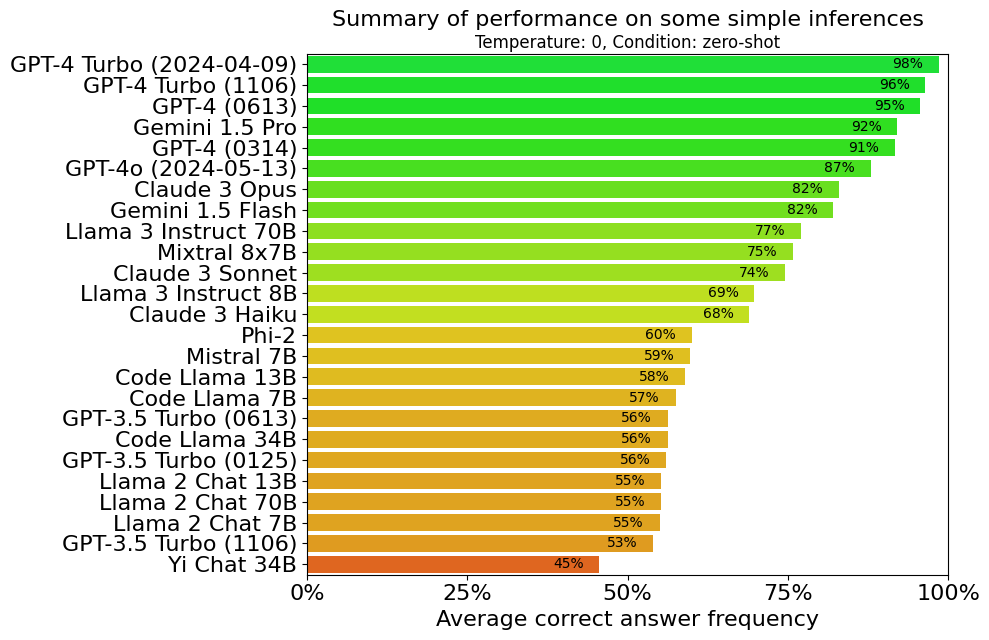

Processing temperature: 1


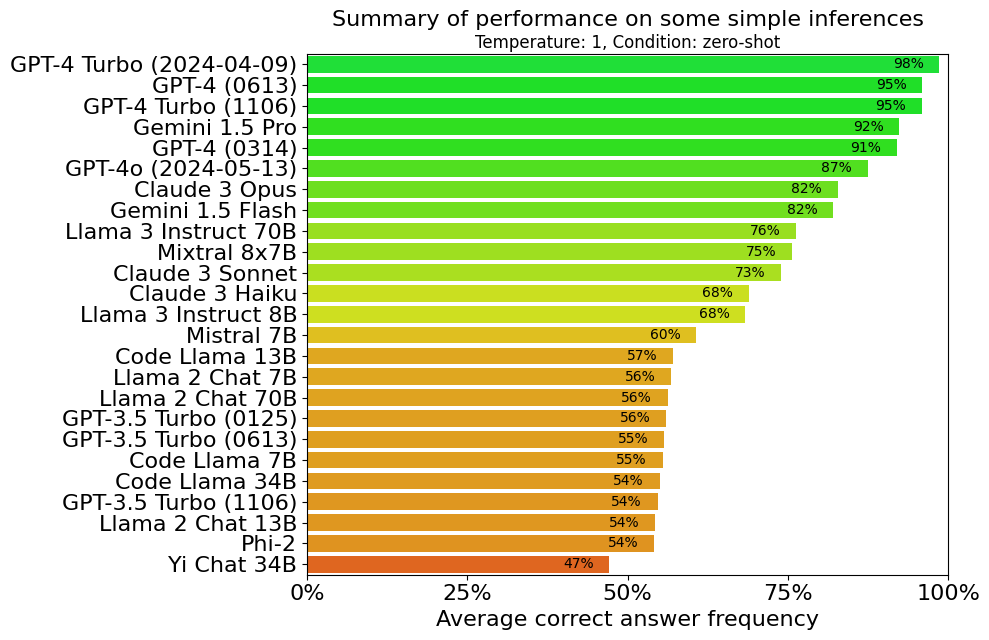

In [18]:
create_performance_summary(df, condition, models_not_finished, correct_answers)

## 4.2 Figure 5: Correlations with LMSYS, MMLU, and GSM8K

### LMSYS Elo scores

In [19]:
with open('external_data/online_elo_ratings.json') as f:
    online_elo_ratings = json.load(f)

In [20]:
elo_df = pd.DataFrame(columns=["model", "elo"])

rows = []

for mod in model_dict.keys():
    if model_dict[mod][3] is not None:
        model_display_name = model_dict[mod][1]
        model_elo = online_elo_ratings[model_dict[mod][3]]
        # Append a dictionary to the list
        rows.append({"model": model_display_name, "elo": model_elo})

# Convert the list of rows to a DataFrame and concatenate
elo_df = pd.concat([elo_df, pd.DataFrame(rows)], ignore_index=True)

In [21]:
elo_df

,model,elo
0,Claude 3 Haiku,991.025542
1,Claude 3 Sonnet,1012.166337
2,Claude 3 Opus,1061.814868
3,Code Llama 34B,934.386734
4,Gemini 1.5 Flash,1023.491603
5,Gemini 1.5 Pro,1052.496807
6,GPT-3.5 Turbo (0613),999.736769
7,GPT-3.5 Turbo (1106),938.030793
8,GPT-3.5 Turbo (0125),917.313146
9,GPT-4 (0613),996.160058


### MMLU

In [22]:
mmlu_df = pd.DataFrame(columns=["model", "mmlu"])

mmlu_scores = {
    'Claude 3 Haiku': 75.2, # https://chat.lmsys.org/ 
    'Claude 3 Opus': 86.8, # https://chat.lmsys.org/
    'Claude 3 Sonnet': 79, # https://chat.lmsys.org/
    'Code Llama 7B': 34.54, # https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard
    'Code Llama 13B': 38.89, # https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard
    'Code Llama 34B': 53.7, #55.54, # https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard
    'Gemini 1.5 Flash': 78.9, # https://chat.lmsys.org/
    'Gemini 1.5 Pro': 85.9, # https://chat.lmsys.org/
    'GPT-4 (0314)': 86.4, # https://chat.lmsys.org/
    'GPT-4o (2024-05-13)': 88.7, # https://chat.lmsys.org/
    'Llama 2 Chat 7B': 45.8, # https://chat.lmsys.org/
    'Llama 2 Chat 13B': 53.6, # https://chat.lmsys.org/
    'Llama 2 Chat 70B': 63, # https://chat.lmsys.org/
    'Llama 3 Instruct 8B': 67.07, # https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard
    'Llama 3 Instruct 70B': 82, #80.06, # https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard
    'Mistral 7B': 60.78, # https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard
    'Mixtral 8x7B': 70.6, #71.4, # https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard
    'Phi-2': 58.11, # https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard
    'Yi Chat 34B': 73.5 #74.9, #  https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard
}

rows = []

for mod in mmlu_scores.keys():
    # Append a dictionary to the list
    rows.append({"model": mod, "mmlu": mmlu_scores[mod]})

mmlu_df = pd.concat([mmlu_df, pd.DataFrame(rows)], ignore_index=True)

In [23]:
mmlu_df

,model,mmlu
0,Claude 3 Haiku,75.20
1,Claude 3 Opus,86.80
2,Claude 3 Sonnet,79.00
3,Code Llama 7B,34.54
4,Code Llama 13B,38.89
5,Code Llama 34B,53.70
6,Gemini 1.5 Flash,78.90
7,Gemini 1.5 Pro,85.90
8,GPT-4 (0314),86.40
9,GPT-4o (2024-05-13),88.70


### GSM8K

In [24]:
gsm8k_df = pd.DataFrame(columns=["model", "gsm8k"])

gsm8k_scores = {
    'Code Llama 7B': 18.6,
    'Code Llama 13B': 27.7,
    'Code Llama 34B': 41.5,
    'Llama 3 Instruct 8B': 75.2,
    'Llama 3 Instruct 70B': 89.6,
    'Mixtral 8x7B': 64.1,
    'GPT-4 Turbo (2024-04-09)': 89.8,
    'GPT-4 (0613)': 91.0,
    'GPT 3.5 Turbo (0125)': 76.0,
    'Claude 3 Opus': 80.2,
    'Claude 3 Sonnet': 72.0,
    'Claude 3 Haiku': 78.5,
    'Phi-2': 56.9,
    'Yi Chat 34B': 64.1,
}

rows = []

for mod in gsm8k_scores.keys():
    # Append a dictionary to the list
    rows.append({"model": mod, "gsm8k": gsm8k_scores[mod]})

gsm8k_df = pd.concat([gsm8k_df, pd.DataFrame(rows)], ignore_index=True)

In [25]:
gsm8k_df

,model,gsm8k
0,Code Llama 7B,18.6
1,Code Llama 13B,27.7
2,Code Llama 34B,41.5
3,Llama 3 Instruct 8B,75.2
4,Llama 3 Instruct 70B,89.6
5,Mixtral 8x7B,64.1
6,GPT-4 Turbo (2024-04-09),89.8
7,GPT-4 (0613),91.0
8,GPT 3.5 Turbo (0125),76.0
9,Claude 3 Opus,80.2


In [26]:
# Define the symbols and a list of colors
symbols = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'h', 'H', '*', 'P', 'X', 'd', '|', '_', '+', 'x', '1', '2', '3', '4', '8']
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(len(cmap.colors))]

# Initialize a global dictionary to map models to symbols and colors
model_symbols_colors = {}

def assign_symbol_color_pairs(models):
    global model_symbols_colors
    
    # Sort the models to ensure deterministic assignment
    sorted_models = sorted(models)
    
    pair_index = 0
    
    for model in sorted_models:
        # Assign the next available (symbol, color) pair
        symbol = symbols[pair_index % len(symbols)]
        color = colors[pair_index % len(colors)]
        model_symbols_colors[model] = (symbol, color)
        pair_index += 1

def correlation_ci(r, n, alpha=0.05):
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    lo = z - z_crit * se
    hi = z + z_crit * se
    return np.tanh((lo, hi))

def plot_correlations(mean_correct_response_df, benchmark_df, benchmark_name, xlabel, ylabel, title, ax, temp, condition, y_padding_top=0.1, y_padding_bottom=0.1):
    # Merging mean_correct_response_df with benchmark_df on 'model'
    merged_df = pd.merge(mean_correct_response_df, benchmark_df, on='model')

    # Dropping rows with None (NaN) values in the benchmark
    merged_df = merged_df.dropna(subset=[benchmark_name])

    # Calculate Pearson correlation coefficient
    correlation, p_value = stats.pearsonr(merged_df['correct_response_percentage'], merged_df[benchmark_name])
    n = len(merged_df)  # Sample size

    # Calculate means and standard deviations
    mean_correct_response = merged_df['correct_response_percentage'].mean()
    std_correct_response = merged_df['correct_response_percentage'].std()
    mean_benchmark = merged_df[benchmark_name].mean()
    std_benchmark = merged_df[benchmark_name].std()

    print(f'Correlation between correct response percentage and {ylabel} score: {correlation}')
    print(f'P-value: {p_value}')
    print(f'Sample size: {n}')
    print(f'Mean Correct Response Percentage: {mean_correct_response} (SD: {std_correct_response})')
    print(f'Mean {ylabel} Score: {mean_benchmark} (SD: {std_benchmark})')


    ci_low, ci_high = correlation_ci(correlation, n)
    print(f'95% Confidence Interval for the Correlation: ({ci_low}, {ci_high})')
    print("")

    # Sorting the dataframe by 'correct_response_percentage' in descending order
    merged_df = merged_df.sort_values(by='correct_response_percentage', ascending=False)

    # Plot each model
    for model in merged_df['model'].unique():
        symbol, color = model_symbols_colors[model]
        subset = merged_df[merged_df['model'] == model]
        ax.scatter(subset['correct_response_percentage'], subset[benchmark_name], 
                   label=model, color=color, marker=symbol, s=100)

    # Plotting the regression line
    sns.regplot(x='correct_response_percentage', y=benchmark_name, data=merged_df, scatter=False, color='black', ax=ax)

    # Setting x-ticks and y-ticks automatically based on the data
    x_min, x_max = merged_df['correct_response_percentage'].min(), merged_df['correct_response_percentage'].max()
    y_min, y_max = merged_df[benchmark_name].min(), merged_df[benchmark_name].max()
    ax.set_xlim(x_min - 2, x_max + 2)  # Tighten up the x-axis

    # Automatically calculating y-limits with independent padding for top and bottom
    padding_top = y_padding_top * (y_max - y_min)
    padding_bottom = y_padding_bottom * (y_max - y_min)
    ax.set_ylim(y_min - padding_bottom, y_max + padding_top)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)  # Increase pad to move title up
    ax.text(0.5, 1.02, f'Temperature: {temp}, Condition: {condition}', ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.grid(True)

def create_performance_correlation_graphs(df, condition, models_not_finished, correct_answers, elo_df, mmlu_df, gsm8k_df):
    global model_symbols_colors

    # Extract unique temperature values from the DataFrame, including handling None
    temperatures = df['temperature'].unique().tolist()
    print(f"Unique temperatures found in the DataFrame: {temperatures}")
    print("")

    if not temperatures:
        print("No temperatures found in the DataFrame.")
        return

    all_models = set(df['model'].unique())
    assign_symbol_color_pairs(all_models)

    for temp in temperatures:
        print(f"Processing temperature: {temp}")
        print("")

        # Read the mean_correct_response_df from the saved json file
        mean_correct_response_df = pd.read_json(f"results/{condition}/mean_correct_response_{condition}_temp_{temp}.json")

        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        plot_correlations(mean_correct_response_df, elo_df, 'elo', 'Correct Response Percentage', 'LMSYS Elo score', 'Performance vs. LMSYS Elo score', axs[0], temp, condition, y_padding_top=0, y_padding_bottom=0.05)
        plot_correlations(mean_correct_response_df, mmlu_df, 'mmlu', 'Correct Response Percentage', 'MMLU score', 'Performance vs. MMLU score', axs[1], temp, condition, y_padding_top=0.17, y_padding_bottom=0.1)
        plot_correlations(mean_correct_response_df, gsm8k_df, 'gsm8k', 'Correct Response Percentage', 'GSM8K score', 'Performance vs. GSM8K score', axs[2], temp, condition, y_padding_top=0.4, y_padding_bottom=0.15)

        # Add % sign to the x-axis ticks
        for ax in axs:
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

        # Shared legend
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center left', bbox_to_anchor=(.99, 0.5), title='Model', title_fontsize='large', fontsize='large', frameon=False)
        fig.tight_layout(pad=1.0)

        combined_plot_path = f'graphs/{condition}/combined_correlations_{temp}_{condition}.pdf'
        plt.savefig(combined_plot_path, format='pdf', bbox_inches='tight')

        plt.show()


Unique temperatures found in the DataFrame: [0, 1]

Processing temperature: 0

Correlation between correct response percentage and LMSYS Elo score score: 0.7401933480135112
P-value: 0.00012491008670186007
Sample size: 21
Mean Correct Response Percentage: 71.20039682539047 (SD: 16.673553884527422)
Mean LMSYS Elo score Score: 988.2973403848569 (SD: 57.39098397079715)
95% Confidence Interval for the Correlation: (0.4533738906516256, 0.8881030618311813)

Correlation between correct response percentage and MMLU score score: 0.7728228016421478
P-value: 0.00010487240392439768
Sample size: 19
Mean Correct Response Percentage: 68.76096491227368 (SD: 14.134882933001785)
Mean MMLU score Score: 67.49947368421053 (SD: 16.680426144864196)
95% Confidence Interval for the Correlation: (0.49094753621807624, 0.9082242283863454)

Correlation between correct response percentage and GSM8K score score: 0.7236778419032108
P-value: 0.005168359097044189
Sample size: 13
Mean Correct Response Percentage: 70.8974

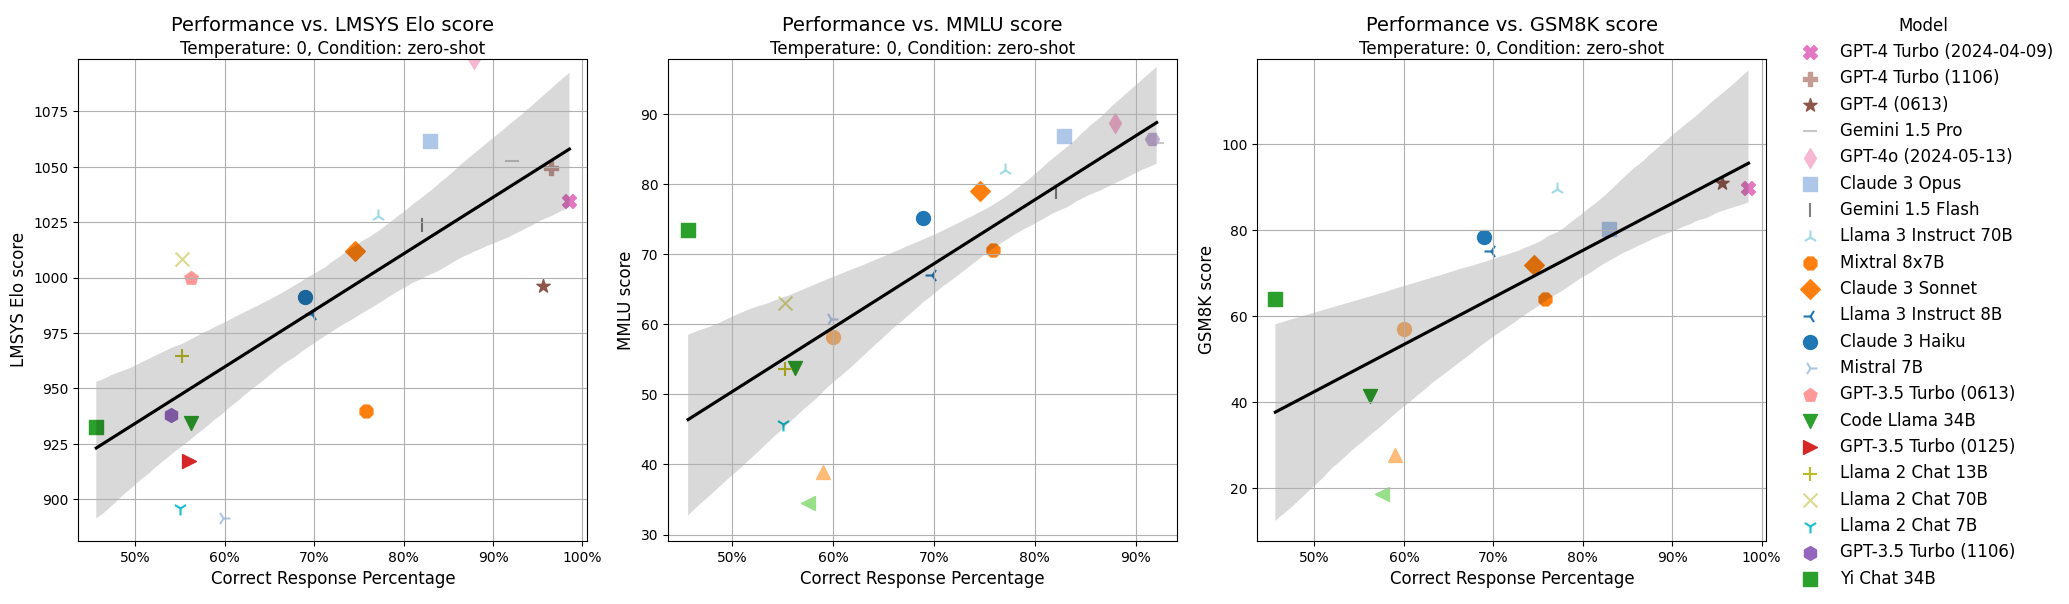

Processing temperature: 1

Correlation between correct response percentage and LMSYS Elo score score: 0.7297251996639104
P-value: 0.0001737537432578366
Sample size: 21
Mean Correct Response Percentage: 71.19494047619048 (SD: 16.456739817003275)
Mean LMSYS Elo score Score: 988.2973403848569 (SD: 57.390983970797144)
95% Confidence Interval for the Correlation: (0.4351006645893639, 0.8831944819186927)

Correlation between correct response percentage and MMLU score score: 0.7950303027507699
P-value: 4.7470450523386214e-05
Sample size: 19
Mean Correct Response Percentage: 68.25877192982107 (SD: 14.341733541587246)
Mean MMLU score Score: 67.49947368421051 (SD: 16.680426144864196)
95% Confidence Interval for the Correlation: (0.533458176668784, 0.91780932820328)

Correlation between correct response percentage and GSM8K score score: 0.7433179759271571
P-value: 0.003591826014180238
Sample size: 13
Mean Correct Response Percentage: 69.95592948717692 (SD: 16.13660811375474)
Mean GSM8K score Scor

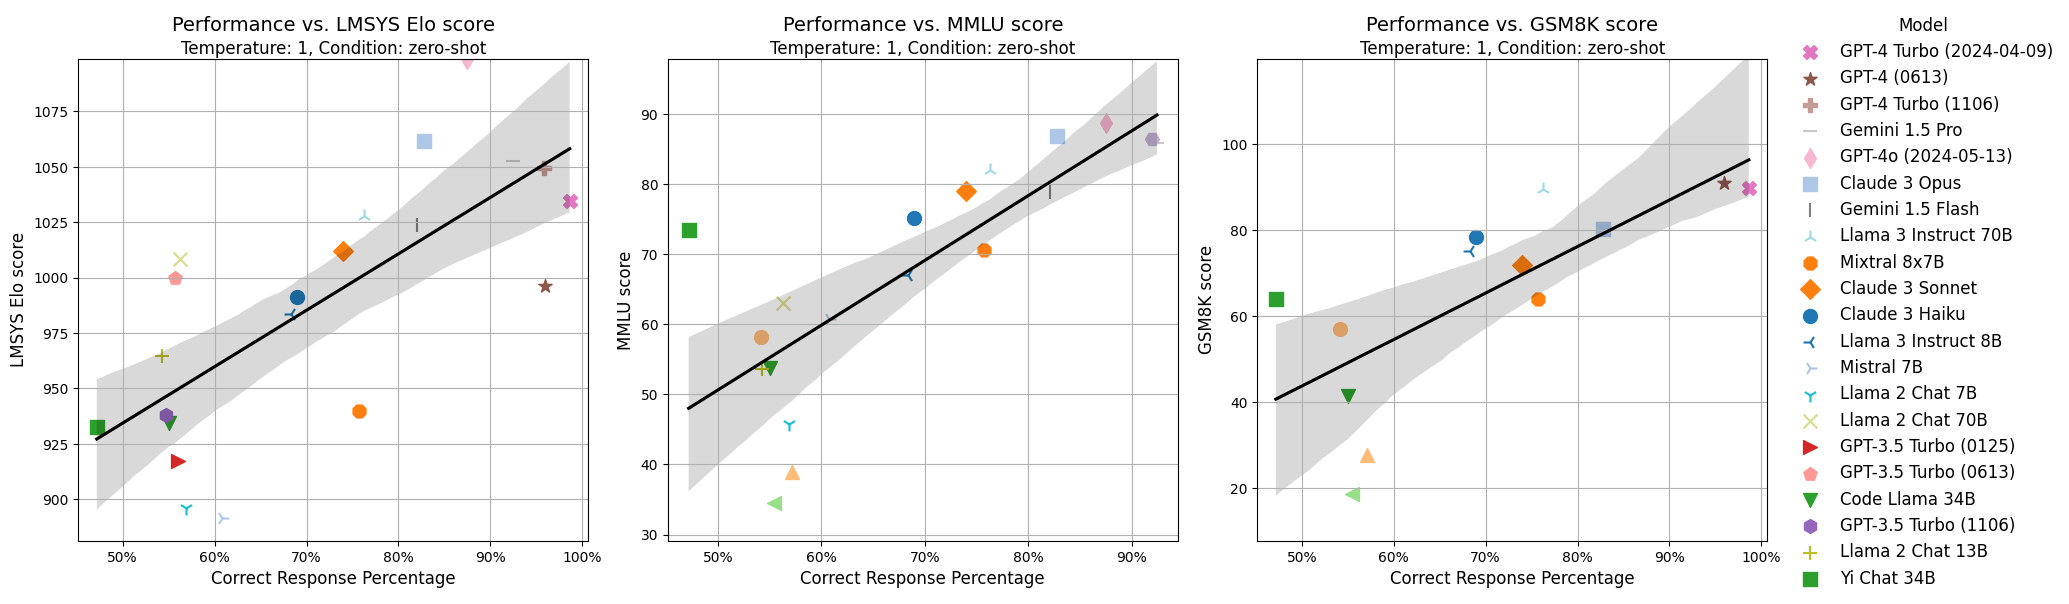

In [27]:
create_performance_correlation_graphs(df, condition, models_not_finished, correct_answers, elo_df, mmlu_df, gsm8k_df)

## 4.3 Table 2: Deltas for few-shot and chain-of-thought

In [28]:
zero_shot_performance = json.load(open('results/zero-shot/mean_correct_response_zero-shot_temp_0.json'))
few_shot_performance = json.load(open('results/few-shot/mean_correct_response_few-shot_temp_0.json'))
chain_of_thought_performance = json.load(open('results/chain_of_thought/mean_correct_response_chain_of_thought_temp_0.json'))

zero_shot_performance_sorted_by_model = sorted(zero_shot_performance, key=lambda x: x["model"])
few_shot_performance_sorted_by_model = sorted(few_shot_performance, key=lambda x: x["model"])
chain_of_thought_performance_sorted_by_model = sorted(chain_of_thought_performance, key=lambda x: x["model"])

assert [d['model'] for d in zero_shot_performance_sorted_by_model] == [d['model'] for d in few_shot_performance_sorted_by_model] == [d['model'] for d in chain_of_thought_performance_sorted_by_model]

In [29]:
# Extracting model names
models = [entry['model'] for entry in zero_shot_performance_sorted_by_model]

# Calculating deltas
few_shot_deltas = []
chain_of_thought_deltas = []

for zero, few, cot in zip(zero_shot_performance_sorted_by_model, few_shot_performance_sorted_by_model, chain_of_thought_performance_sorted_by_model):
    few_shot_deltas.append(few['correct_response_percentage'] - zero['correct_response_percentage'])
    chain_of_thought_deltas.append(cot['correct_response_percentage'] - zero['correct_response_percentage'])

# Printing deltas
for model, few_delta, cot_delta in zip(models, few_shot_deltas, chain_of_thought_deltas):
    print(f"Model: {model}")
    print(f"  Few-shot delta: {few_delta:.4f}%")
    print(f"  Chain of Thought delta: {cot_delta:.4f}%")
    print("")

# Conducting paired t-tests
few_shot_ttest = stats.ttest_rel([entry['correct_response_percentage'] for entry in zero_shot_performance_sorted_by_model],
                                 [entry['correct_response_percentage'] for entry in few_shot_performance_sorted_by_model])
chain_of_thought_ttest = stats.ttest_rel([entry['correct_response_percentage'] for entry in zero_shot_performance_sorted_by_model],
                                         [entry['correct_response_percentage'] for entry in chain_of_thought_performance_sorted_by_model])

print(f"\nPaired t-test for zero-shot vs. few-shot:")
print("t-statistic =", few_shot_ttest.statistic)
print(f"p-value = {few_shot_ttest.pvalue:.4e}")
print("")

print(f"Paired t-test for zero-shot vs. chain of thought:")
print("t-statistic =", chain_of_thought_ttest.statistic)
print(f"p-value = {chain_of_thought_ttest.pvalue:.4e}")

Model: Claude 3 Haiku
  Few-shot delta: -3.1250%
  Chain of Thought delta: 7.7083%

Model: Claude 3 Opus
  Few-shot delta: 6.8750%
  Chain of Thought delta: 14.5833%

Model: Claude 3 Sonnet
  Few-shot delta: 3.9583%
  Chain of Thought delta: 10.2083%

Model: Code Llama 13B
  Few-shot delta: -8.9583%
  Chain of Thought delta: 7.7083%

Model: Code Llama 34B
  Few-shot delta: -6.4583%
  Chain of Thought delta: 4.3750%

Model: Code Llama 7B
  Few-shot delta: 5.6250%
  Chain of Thought delta: 0.2083%

Model: GPT-3.5 Turbo (0125)
  Few-shot delta: 2.0833%
  Chain of Thought delta: 22.5000%

Model: GPT-3.5 Turbo (0613)
  Few-shot delta: 1.6667%
  Chain of Thought delta: 13.7500%

Model: GPT-3.5 Turbo (1106)
  Few-shot delta: -0.4167%
  Chain of Thought delta: 15.8333%

Model: GPT-4 (0314)
  Few-shot delta: 5.8333%
  Chain of Thought delta: 7.7083%

Model: GPT-4 (0613)
  Few-shot delta: 0.2083%
  Chain of Thought delta: 3.1250%

Model: GPT-4 Turbo (1106)
  Few-shot delta: 0.0000%
  Chain of Th

## 4.4 Figures with green bars: average frequency of correct answer

In [30]:
for temp in temperatures:
    # Filter the dataframe for selected temperature
    df_filtered = df[df['temperature'] == temp]

    unique_prompt_classes = df_filtered['prompt_class'].unique()

    model_order = ["GPT-4o (2024-05-13)", 
                    "GPT-4 Turbo (2024-04-09)", 
                    "GPT-4 Turbo (1106)", 
                    "GPT-4 (0613)", "GPT-4 (0314)",
                   "Claude 3 Opus", "Gemini 1.5 Pro",
                   "GPT-3.5 Turbo (0125)", "GPT-3.5 Turbo (1106)", "GPT-3.5 Turbo (0613)",
                   "Claude 3 Sonnet",
                   "Gemini 1.5 Flash",
                   "Llama 3 Instruct 70B", "Llama 2 Chat 70B", "Mixtral 8x7B",
                    "Yi Chat 34B", "Code Llama 34B", 
                    "Claude 3 Haiku",
                    "Code Llama 13B", "Llama 2 Chat 13B", 
                    "Llama 3 Instruct 8B", "Mistral 7B", "Code Llama 7B", "Llama 2 Chat 7B", 
                    "Phi-2"]
    
    model_shortened_names = {name:name for name in model_order}
    #model_shortened_names["GPT-4 (0613)"] = "GPT-4"
    #model_shortened_names["GPT-3.5 Turbo (0613)"] = "GPT-3.5 Turbo"

    # Colors from the seaborn "bright" palette
    bright_palette = sns.color_palette("bright")
    bright_color = bright_palette[2] # Choosing a color for the correct answer

    # Dictionary to store file paths for each prompt's graph
    percent_graph_paths = {}

    for prompt_class in tqdm(unique_prompt_classes):
        # Filtering for the current prompt class
        prompt_class_df = df_filtered[df_filtered['prompt_class'] == prompt_class].copy()
        prompt_class_df['model'] = pd.Categorical(prompt_class_df['model'], categories=model_order, ordered=True)
        prompt_class_df['model'] = prompt_class_df['model'].replace(model_shortened_names)

        # Select the correct percentage based on the correct answer
        correct_percent_column = 'yes_percent' if correct_answers[prompt_class] == 'yes' else 'no_percent'
        prompt_class_df[correct_percent_column] = abs(prompt_class_df[correct_percent_column]) * 100  # Converting to positive percentage

        # Creating a multi-line title
        prompt = prompt_class +  " example: " + prompt_class_df['prompt'].iloc[0]
        words = prompt.split()
        title_lines = []
        line = ""
        for word in words:
            if len(line) + len(word) <= 55:
                line += word + " "
            else:
                title_lines.append(line.strip())
                line = word + " "
        title_lines.append(line.strip()) # Append the last line
        title = "\n".join(title_lines)

        # Creating the plot
        plt.figure(figsize=(9, 7))
        ax = plt.gca()
        plt.title(title, fontsize=16)

        # Plotting bars
        sns.barplot(x=correct_percent_column, y="model", data=prompt_class_df, color=bright_color, edgecolor='black')

        # Extending the x-axis range
        plt.xlabel(f'Correct answer (\'{correct_answers[prompt_class]}\') frequency', fontsize='16')

        # Adding temperature and condition text below the xlabel
        plt.text(0.5, -0.15, f'Temperature: {temp}, Condition: {condition}', ha='center', va='center', transform=ax.transAxes, fontsize=12)

        plt.ylabel('')
        plt.xlim(0, 105) # Extending x-axis to 110% for visual clarity

        # Adjusting the x-axis ticks and labels
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])

        plt.yticks(fontsize='16') 
        plt.xticks(fontsize='16') 

        ax.legend([], [], frameon=False)
        plt.tight_layout()

        # Save the plot
        output_file = f'graphs/{condition}/correct_freq_for_{prompt_class}_temp_{temp}_{condition}.pdf'
        plt.savefig(output_file, format='pdf')
        plt.close()

        # Updating the dictionary with the new file paths
        percent_graph_paths[prompt_class] = output_file

    # Output the paths of the saved graphs with extended x-axis
    print(percent_graph_paths)


  0%|          | 0/103 [00:00<?, ?it/s]

{'DSx': 'graphs/zero-shot/correct_freq_for_DSx_temp_0_zero-shot.pdf', 'DSmufo': 'graphs/zero-shot/correct_freq_for_DSmufo_temp_0_zero-shot.pdf', 'MTmuo': 'graphs/zero-shot/correct_freq_for_MTmuo_temp_0_zero-shot.pdf', 'vAC': 'graphs/zero-shot/correct_freq_for_vAC_temp_0_zero-shot.pdf', 'NMu': 'graphs/zero-shot/correct_freq_for_NMu_temp_0_zero-shot.pdf', 'MTox': 'graphs/zero-shot/correct_freq_for_MTox_temp_0_zero-shot.pdf', 'uMP': 'graphs/zero-shot/correct_freq_for_uMP_temp_0_zero-shot.pdf', 'uDA': 'graphs/zero-shot/correct_freq_for_uDA_temp_0_zero-shot.pdf', 'uCONV': 'graphs/zero-shot/correct_freq_for_uCONV_temp_0_zero-shot.pdf', 'CMP': 'graphs/zero-shot/correct_freq_for_CMP_temp_0_zero-shot.pdf', 'MTmu': 'graphs/zero-shot/correct_freq_for_MTmu_temp_0_zero-shot.pdf', 'vMT': 'graphs/zero-shot/correct_freq_for_vMT_temp_0_zero-shot.pdf', 'LAC': 'graphs/zero-shot/correct_freq_for_LAC_temp_0_zero-shot.pdf', 'uMTmi': 'graphs/zero-shot/correct_freq_for_uMTmi_temp_0_zero-shot.pdf', 'DSmuo': 'g

  0%|          | 0/103 [00:00<?, ?it/s]

{'DSx': 'graphs/zero-shot/correct_freq_for_DSx_temp_1_zero-shot.pdf', 'DSmufo': 'graphs/zero-shot/correct_freq_for_DSmufo_temp_1_zero-shot.pdf', 'MTmuo': 'graphs/zero-shot/correct_freq_for_MTmuo_temp_1_zero-shot.pdf', 'vAC': 'graphs/zero-shot/correct_freq_for_vAC_temp_1_zero-shot.pdf', 'NMu': 'graphs/zero-shot/correct_freq_for_NMu_temp_1_zero-shot.pdf', 'MTox': 'graphs/zero-shot/correct_freq_for_MTox_temp_1_zero-shot.pdf', 'uMP': 'graphs/zero-shot/correct_freq_for_uMP_temp_1_zero-shot.pdf', 'uDA': 'graphs/zero-shot/correct_freq_for_uDA_temp_1_zero-shot.pdf', 'uCONV': 'graphs/zero-shot/correct_freq_for_uCONV_temp_1_zero-shot.pdf', 'CMP': 'graphs/zero-shot/correct_freq_for_CMP_temp_1_zero-shot.pdf', 'MTmu': 'graphs/zero-shot/correct_freq_for_MTmu_temp_1_zero-shot.pdf', 'vMT': 'graphs/zero-shot/correct_freq_for_vMT_temp_1_zero-shot.pdf', 'LAC': 'graphs/zero-shot/correct_freq_for_LAC_temp_1_zero-shot.pdf', 'uMTmi': 'graphs/zero-shot/correct_freq_for_uMTmi_temp_1_zero-shot.pdf', 'DSmuo': 'g

## 4.5 Figures with orange bars: average frequency of 'no' and average frequency of 'yes'

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

for temp in temperatures:
    # Filter the dataframe for the selected temperature
    df_filtered = df[df['temperature'] == temp]

    unique_prompt_classes = df_filtered['prompt_class'].unique()

    model_order = ["GPT-4o (2024-05-13)", 
                    "GPT-4 Turbo (2024-04-09)", 
                    "GPT-4 Turbo (1106)", 
                    "GPT-4 (0613)", "GPT-4 (0314)",
                   "Claude 3 Opus", "Gemini 1.5 Pro",
                   "GPT-3.5 Turbo (0125)", "GPT-3.5 Turbo (1106)", "GPT-3.5 Turbo (0613)",
                   "Claude 3 Sonnet",
                   "Gemini 1.5 Flash",
                   "Llama 3 Instruct 70B", "Llama 2 Chat 70B", "Mixtral 8x7B",
                    "Yi Chat 34B", "Code Llama 34B", 
                    "Claude 3 Haiku",
                    "Code Llama 13B", "Llama 2 Chat 13B", 
                    "Llama 3 Instruct 8B", "Mistral 7B", "Code Llama 7B", "Llama 2 Chat 7B", 
                    "Phi-2"]
    
    model_shortened_names = {name:name for name in model_order}
    #model_shortened_names["GPT-4 (0613)"] = "GPT-4"
    #model_shortened_names["GPT-3.5 Turbo (0613)"] = "GPT-3.5 Turbo"

    # Colors from the seaborn "bright" palette
    bright_palette = sns.color_palette("bright")
    bright_orange = bright_palette[1]

    # Dictionary to store file paths for each prompt's graph
    percent_graph_paths = {}

    for prompt_class in tqdm(unique_prompt_classes):
        # Filtering for the current prompt class
        prompt_class_df = df_filtered[df_filtered['prompt_class'] == prompt_class].copy()
        prompt_class_df['model'] = pd.Categorical(prompt_class_df['model'], categories=model_order, ordered=True)
        prompt_class_df['model'] = prompt_class_df['model'].replace(model_shortened_names)

        # Converting frequencies to percentages
        prompt_class_df['yes_percent'] *= 100
        prompt_class_df['no_percent'] *= 100

        # Creating a multi-line title
        prompt = prompt_class + " example: " + prompt_class_df['prompt'].iloc[0]
        words = prompt.split()
        title_lines = []
        line = ""
        for word in words:
            if len(line) + len(word) <= 60:
                line += word + " "
            else:
                title_lines.append(line.strip())
                line = word + " "
        title_lines.append(line.strip())  # Append the last line
        title = "\n".join(title_lines)

        # Creating the plot
        plt.figure(figsize=(8, 8))
        ax = plt.gca()
        plt.title(title, fontsize=16)

        # Plotting bars
        sns.barplot(x="yes_percent", y="model", data=prompt_class_df, color=bright_orange, edgecolor='black')
        sns.barplot(x="no_percent", y="model", data=prompt_class_df, color=bright_orange, edgecolor='black')

        plt.xlabel('')
        plt.ylabel('')
        plt.xlim(-105, 105)
        plt.axvline(x=0, color='black', linewidth=1)

        # Adding text
        font_size = plt.rcParams['axes.labelsize']
        ax.text(50, -0.07, "'Yes' Frequency", ha="center", va="top", transform=ax.get_xaxis_transform(), fontsize=16)
        ax.text(-50, -0.07, "'No' Frequency", ha="center", va="top", transform=ax.get_xaxis_transform(), fontsize=16)

        # Adding temperature and condition text below the xlabel
        plt.text(0.5, -0.125, f'Temperature: {temp}, Condition: {condition}', ha='center', va='top', transform=ax.transAxes, fontsize=12)

        ax.set_xticks([-100, -50, 0, 50, 100])
        ax.set_xticklabels(['100%', '50%', '0', '50%', '100%'])

        ax.legend([], [], frameon=False)
        plt.tight_layout()

        # Adjust subplots if necessary (modify these values as needed)
        plt.subplots_adjust(top=0.9, bottom=0.2, left=0.1, right=0.9, hspace=0.2, wspace=0.2)

        plt.yticks(fontsize='16') 
        plt.xticks(fontsize='16') 

        # Save the plot
        output_file = f'graphs/{condition}/percent_graph_for_{prompt_class}_temp_{temp}_{condition}.pdf'
        plt.savefig(output_file, format='pdf', bbox_inches='tight')
        plt.close()

        # Updating the dictionary with the new file paths
        percent_graph_paths[prompt_class] = output_file

        #plt.show()

    # Output the paths of the saved graphs
    percent_graph_paths


100%|██████████| 103/103 [00:51<00:00,  1.98it/s]


## 4.4 Fig 3: consistency on DSmu, DSmi, and MiN

In [32]:
cc_model_nums = [3, 8, 14, 15, 16]

In [33]:
cc_condition = 'consistency-check' # 'consistency-check' or 'consistency-check-chain-of-thought'
cc_temperature = 0

In [34]:
cc_prompt_class_sets = [['MiN_match', 'DSmi', 'DSmu']] # [['MiN_match', 'NMu_match', 'DSmi', 'DSmu'], ['MiN_match', 'DSmi', 'DSmu'], ['DSmi', 'DSmu']]
all_cc_prompt_classes = ['MiN_match', 'DSmi', 'DSmu']

cc_user_prompts = list()
cc_prompt_classes = list()

for file in os.listdir('prompts'):
    if file.endswith('.json'):
        prompt_class = file[:-5]
        if prompt_class in all_cc_prompt_classes:
            with open('prompts/' + file) as f:
                cc_user_prompts += json.load(f)

In [35]:
collect_consistency_data = False
verbose = False

if collect_consistency_data:

    for model_num in cc_model_nums:

        model_short_name = model_dict[model_num][0]
        model_display_name = model_dict[model_num][1]
        model_full_name = model_dict[model_num][2]
        model_lmsys_name = model_dict[model_num][3]

        print("Model:", model_display_name)

        for prompt_class_set in cc_prompt_class_sets:

            if len(prompt_class_set) > 1:

                if cc_condition == 'consistency-check':

                    cc_system_prompt = f"You will see a series of {len(prompt_class_set)} yes/no questions. Please respond with {len(prompt_class_set)} answers separated by commas. The first answer is for the first question, the second answer is for the second question, etc. Each answer should be either 'yes' or 'no' and nothing else."
                    cc_max_tokens = 8

                if cc_condition == 'consistency-check-chain-of-thought':

                    cc_system_prompt = f"You will see a series of {len(prompt_class_set)} yes/no questions. Think step by step about each question and explain your reasoning. Then when you are ready to answer all the questions, please write 'Answer: ' followed by {len(prompt_class_set)} answers separated by commas. The first answer is for the first question, the second answer is for the second question, etc. Each answer should be either 'yes' or 'no' and nothing else."
                    cc_max_tokens = 4096

                print("System prompt:")
                print(cc_system_prompt)
                print("")

                for prompt_classes in tqdm(list(permutations(prompt_class_set))):

                    if verbose:
                        print("Prompt classes:")
                        print(prompt_classes)
                        print("")

                    tuples = list()

                    for n in range(1,21):

                        question = dict()

                        for up in cc_user_prompts:

                            for k in range(len(prompt_class_set)):

                                if up[0] == prompt_classes[k] and up[1] == n:

                                    question[k] = up[2]

                        question_list = list()

                        for k in range(len(prompt_class_set)):
                            question_list.append(question[k])

                        tuples.append(question_list)

                    
                    for prompt_num in range(20):

                        cc_user_prompt = ""

                        for k in range(len(prompt_class_set)):

                            cc_user_prompt += f"Question {k+1}: {tuples[prompt_num][k]}\n"

                        if verbose:
                            print("User prompt:")
                            print(cc_user_prompt)

                        data = {
                            "prompt_classes": prompt_classes,
                            "user_prompt": cc_user_prompt,
                            "system_prompt": cc_system_prompt,
                            "model": model_full_name,
                            "temperature": cc_temperature,
                            "responses": []
                        }
                        
                        # if the data file already exists, continue
                        if os.path.exists(f'data/{cc_condition}/{model_short_name}/{prompt_classes}/{model_short_name}_{prompt_classes}_{prompt_num}_{cc_temperature}.json'):
                            continue
                            
                        for k in range(num_prompts_per_temp[cc_temperature]):

                            if model_short_name in ['gpt_4o_2024_05_13','gpt_4_turbo_2024_04_09', 'gpt_4_turbo_1106', 'gpt_4_0613', 'gpt_4_0314', 'gpt_3_5_turbo_1106', 'gpt_3_5_turbo_0613', 'gpt_3_5_turbo_0125']:

                                client = OpenAI(api_key=OPENAI_API_KEY)
                                completion = client.chat.completions.create(
                                model=model_full_name,
                                messages=[
                                        {"role": "system", "content": cc_system_prompt},
                                        {"role": "user", "content": cc_user_prompt}],
                                temperature=cc_temperature,
                                max_tokens=cc_max_tokens,
                                )
                                print(completion.choices[0].message)
                                message_json = completion.choices[0].message.model_dump_json()
                                answer = json.loads(message_json)

                                data["responses"].append(answer)

                                if verbose:

                                    print("Answer:", answer)
                                    print("----------------------")
                                    print("")
                            
                            elif model_short_name in ['gemini_1-5_pro', 'gemini_1-5_flash']:

                                model = genai.GenerativeModel(model_full_name)
                                response = model.generate_content(
                                    cc_system_prompt + " " + cc_user_prompt,
                                    generation_config=genai.types.GenerationConfig(
                                        candidate_count=1,
                                        max_output_tokens=cc_max_tokens,
                                        temperature=cc_temperature)
                                )
                                text = response.text
                                answer = {"content": text}
                                data["responses"].append(answer)

                                if verbose:
                                    print("Answer:", answer)
                                    print("----------------------")
                                    print("") 
                            
                            elif model_short_name in ['claude_3_5_sonnet_20240620', 'claude_3_opus_20240229', 'claude_3_sonnet_20240229', 'claude_3_haiku_20240307']:

                                client = anthropic.Anthropic(
                                    api_key=ANTHROPIC_API_KEY,
                                )

                                response = client.messages.create(
                                    model=model_full_name,
                                    max_tokens=cc_max_tokens,
                                    temperature=cc_temperature,
                                    system=cc_system_prompt,
                                    messages=[
                                        {"role": "user", "content": cc_user_prompt}
                                    ]
                                )
                                text = response.content[0].text
                                
                                answer = {"content": text}

                                data["responses"].append(answer)

                                if verbose:
                                    print("Answer:", answer)
                                    print("----------------------")
                                    print("") 

                        # create the appropriate directory if it doesn't already exist
                        if not os.path.exists(f'data/{cc_condition}/{model_short_name}/{prompt_classes}'):
                            os.makedirs(f'data/{cc_condition}/{model_short_name}/{prompt_classes}')

                        # Save the data to a JSON file
                        with open(f'data/{cc_condition}/{model_short_name}/{prompt_classes}/{model_short_name}_{prompt_classes}_{prompt_num}_{cc_temperature}.json', 'w') as json_file:
                            json.dump(data, json_file, indent=4)


In [36]:
verbose = True

consistency_data = dict()

for model_num in cc_model_nums:

    model_short_name = model_dict[model_num][0]
    model_display_name = model_dict[model_num][1]
    model_full_name = model_dict[model_num][2]

    if verbose:
        print("Model:", model_display_name)
        print("Condition:", cc_condition)
        print("")

    num_answers = 0
    num_inconsistent_answers = 0

    consistency_frequencies = list()

    for prompt_class_set in cc_prompt_class_sets:

        for prompt_classes in permutations(prompt_class_set):

            num_answers_for_classes = 0
            num_inconsistent_answers_for_classes = 0

            if verbose:
                print("Prompt classes and order:", prompt_classes)

            yes_count = dict()

            for k in range(len(prompt_class_set)):
                yes_count[k] = 0

            for prompt_num in range(20):
                
                    with open(f'data/{cc_condition}/{model_short_name}/{prompt_classes}/{model_short_name}_{prompt_classes}_{prompt_num}_{cc_temperature}.json') as f:
                        data = json.load(f)
                
                    for response in data['responses']:

                        if verbose:
                            print(response['content'])
                            print(after_answer(response['content']))
                            print("------------")

                        answer_dict = dict()
                        
                        for k in range(len(prompt_class_set)):

                            if cc_condition == 'consistency-check':
                                if contains_yes(response['content'].split(',')[k]):
                                    yes_count[k] += 1
                                    
                                    answer_dict[prompt_classes[k]] = 1
                                else:
                                    answer_dict[prompt_classes[k]] = 0

                            if cc_condition == 'consistency-check-chain-of-thought':
                                if contains_yes(after_answer(response['content']).split(',')[k]):
                                    yes_count[k] += 1

                                    answer_dict[prompt_classes[k]] = 1
                                else:
                                    answer_dict[prompt_classes[k]] = 0
                        
                        # The following combination of judgments are logically inconsistent

                        if answer_dict['DSmi'] == 0 and answer_dict['DSmu'] == 1 and answer_dict['MiN_match'] == 1:
                            num_inconsistent_answers += 1
                            num_inconsistent_answers_for_classes += 1

                        num_answers += 1
                        num_answers_for_classes += 1

            if verbose:              
                for k in range(len(prompt_classes)):
                    print(f"Yes frequency for {prompt_classes[k]}:", yes_count[k] / 20)

                print("")

            consistency_frequency_for_prompt_classes = (num_answers_for_classes - num_inconsistent_answers_for_classes) / num_answers_for_classes
            consistency_frequencies.append(consistency_frequency_for_prompt_classes)

            if verbose:
                print("Frequency of consistent answers for prompt classes:", consistency_frequency_for_prompt_classes)
                print("")

    if verbose:
        print("Frequency of consistent answers overall:", (num_answers - num_inconsistent_answers) / num_answers)
        print("")

    consistency_data[model_display_name] = consistency_frequencies

# if the directory doesn't exist, create it

if not os.path.exists(f'results/{cc_condition}'):
    os.makedirs(f'results/{cc_condition}')

# save the consistency data to a JSON file

with open(f'results/{cc_condition}/consistency_data_{cc_condition}.json', 'w') as json_file:
    json.dump(consistency_data, json_file, indent=4)

consistency_data

Model: Claude 3 Opus
Condition: consistency-check

Prompt classes and order: ('MiN_match', 'DSmi', 'DSmu')
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
yes,no,yes
yes,no,yes
------------
Yes frequency for MiN_match: 1.0
Yes frequency for DSmi: 0.0
Yes frequency for DSmu: 1.0

Frequency of consistent answers for prompt classes: 0.0

Prompt classes and order: ('MiN_match', 'DSmu'

{'Claude 3 Opus': [0.0, 0.0, 0.6, 0.05, 0.1, 0.0],
 'Gemini 1.5 Pro': [0.95, 0.0, 1.0, 0.9, 0.65, 0.7],
 'GPT-4 Turbo (1106)': [0.0, 0.0, 0.9, 0.15, 0.0, 0.0],
 'GPT-4 Turbo (2024-04-09)': [0.45, 0.0, 0.5, 0.2, 0.0, 0.0],
 'GPT-4o (2024-05-13)': [0.9, 0.1, 0.1, 0.0, 0.0, 0.0]}

In [37]:
consistency_data_zero_shot = json.load(open('results/consistency-check/consistency_data_consistency-check.json'))
consistency_data_chain_of_thought = json.load(open('results/consistency-check-chain-of-thought/consistency_data_consistency-check-chain-of-thought.json'))

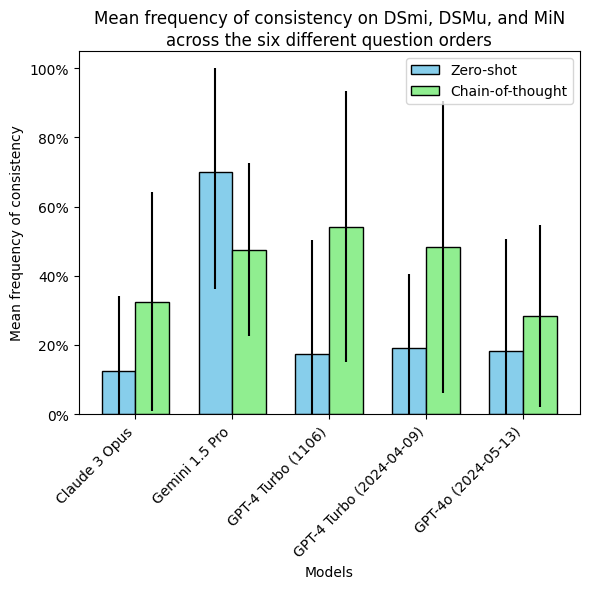

In [38]:
# Combine models from both dictionaries
models = list(consistency_data_zero_shot.keys())
all_means = []
all_std_devs = []
all_conditions = []

for model in models:
    # Zero-shot data
    zero_shot_data = consistency_data_zero_shot[model]
    zero_shot_mean = np.mean(zero_shot_data)
    zero_shot_std = np.std(zero_shot_data)
    all_means.append(zero_shot_mean)
    all_std_devs.append(zero_shot_std)
    all_conditions.append('Zero-shot')

    # Chain-of-thought data
    cot_data = consistency_data_chain_of_thought[model]
    cot_mean = np.mean(cot_data)
    cot_std = np.std(cot_data)
    all_means.append(cot_mean)
    all_std_devs.append(cot_std)
    all_conditions.append('Chain-of-thought')

# Calculate lower and upper bounds for error bars
lower_bounds = [max(0, mean - std) for mean, std in zip(all_means, all_std_devs)]
upper_bounds = [min(1, mean + std) for mean, std in zip(all_means, all_std_devs)]

# Calculate asymmetric error bars
lower_errors = [mean - lower for mean, lower in zip(all_means, lower_bounds)]
upper_errors = [upper - mean for mean, upper in zip(all_means, upper_bounds)]

# Plotting the bar graph with error bars
plt.figure(figsize=(6, 6))

# Create an array for x positions
x = np.arange(len(models))

# Width of the bars
width = 0.35

# Plot zero-shot bars
plt.bar(x - width/2, all_means[::2], width, yerr=[lower_errors[::2], upper_errors[::2]], capsize=0, label='Zero-shot', color='skyblue', edgecolor='black')

# Plot chain-of-thought bars
plt.bar(x + width/2, all_means[1::2], width, yerr=[lower_errors[1::2], upper_errors[1::2]], capsize=0, label='Chain-of-thought', color='lightgreen', edgecolor='black')

plt.xlabel('Models')
plt.ylabel('Mean frequency of consistency')
plt.title('Mean frequency of consistency on DSmi, DSMu, and MiN', pad=20)
plt.text(0.5, 1.03, 'across the six different question orders', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
plt.xticks(x, models, rotation=45, ha='right')

# Format y-tick labels as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

# Adding a legend
plt.legend()

plt.tight_layout()

# Create the appropriate directory if it doesn't already exist
output_directory = 'graphs/combined_conditions'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the plot
plt.savefig(f'{output_directory}/consistency_frequency_combined_conditions.pdf', format='pdf')

# Show the plot
plt.show()

# 5. Supplementary material

## 5.1 Queries and Errors per Model

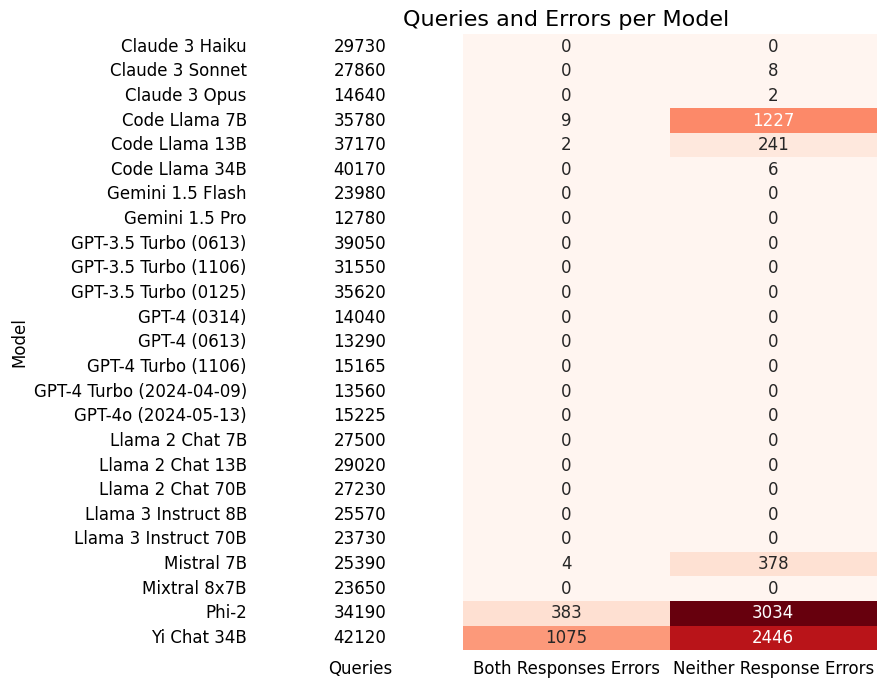

In [39]:
# Prepare data for the heatmap
heatmap_data = pd.DataFrame({
    'Queries': queries_per_model,
    'Both Responses Errors': error_both_response,
    'Neither Response Errors': error_no_response
})

# Set up the matplotlib figure
plt.figure(figsize=(8, 8))

# Create a mask for the Queries per Model column
mask = np.zeros_like(heatmap_data, dtype=bool)
mask[:, 0] = True

# Use rc_context to set font size locally
with plt.rc_context({'font.size': 12}):
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap='Reds', mask=mask, cbar_kws={'label': 'Error Count'}, cbar=False)
    plt.title("Queries and Errors per Model",fontsize=16)
    plt.ylabel("Model")
    plt.xticks(rotation=0, ha='center')
    plt.yticks(rotation=0)

    # Manually annotate the 'Queries per Model' column
    for i, value in enumerate(heatmap_data['Queries']):
        plt.text(0.5, i + 0.5, value, horizontalalignment='center', verticalalignment='center', color='black')

    # Remove ticks on the x and y axes
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

    # Save the plot as a PDF file with a tight layout
    plt.savefig(f'results/{condition}/queries_and_errors_{condition}.pdf', bbox_inches='tight')

#plt.close()
plt.show()

## 5.2 Correlations for sensical vs. non-sensical predicates

In [40]:
prompt_classes_for_correlations = ['AC', 'CMP', 'CONV', 'DA', 'DS', 'DSmi', 'DSmu', 'INV', 'MP', 'MT', 'MTmi', 'MTmu', 'MiN', 
                                   'ACx', 'CMPx', 'CONVx', 'DAx', 'DSx', 'DSmix', 'DSmux', 'INVx', 'MPx', 'MTx', 'MTmix', 'MTmux', 'MiNx']

In [41]:
# Function to calculate average 'yes_percent' for 'x' and non-'x' versions across models and temperatures
def calculate_averages_by_temp(df):
    averages_dict = {}
    for prompt_class in set(pc.rstrip('x') for pc in df['prompt_class']):
        prompt_class_x = prompt_class + 'x'
        for model in df['model'].unique():
            for temp in df['temperature'].unique():
                avg_non_x = df[(df['prompt_class'] == prompt_class) & (df['model'] == model) & (df['temperature'] == temp)]['yes_percent'].mean()
                avg_x = df[(df['prompt_class'] == prompt_class_x) & (df['model'] == model) & (df['temperature'] == temp)]['yes_percent'].mean()
                averages_dict[(prompt_class, model, temp)] = {'avg_non_x': avg_non_x, 'avg_x': avg_x}
    return averages_dict

# Function to calculate correlation across models by temperature for each prompt class
def calculate_correlation_across_models_by_temp(averages_dict):
    correlation_dict = {}
    for (prompt_class, model, temp) in averages_dict:
        key = (prompt_class, temp)
        avg_non_x = averages_dict[(prompt_class, model, temp)]['avg_non_x']
        avg_x = averages_dict[(prompt_class, model, temp)]['avg_x']
        if key not in correlation_dict:
            correlation_dict[key] = {'avg_non_x': [], 'avg_x': []}
        correlation_dict[key]['avg_non_x'].append(avg_non_x)
        correlation_dict[key]['avg_x'].append(avg_x)
    for key in correlation_dict:
        series_non_x = pd.Series(correlation_dict[key]['avg_non_x'])
        series_x = pd.Series(correlation_dict[key]['avg_x'])
        correlation = series_non_x.corr(series_x)
        correlation_dict[key] = correlation
    return correlation_dict

# Function to calculate general correlation across all models and temperatures for each prompt class
def calculate_general_correlation_across_all_models_and_temps(averages_dict):
    correlation_dict = {}
    for key in averages_dict:
        prompt_class = key[0]
        avg_non_x = averages_dict[key]['avg_non_x']
        avg_x = averages_dict[key]['avg_x']
        if prompt_class not in correlation_dict:
            correlation_dict[prompt_class] = {'avg_non_x': [], 'avg_x': []}
        correlation_dict[prompt_class]['avg_non_x'].append(avg_non_x)
        correlation_dict[prompt_class]['avg_x'].append(avg_x)
    for prompt_class in correlation_dict:
        series_non_x = pd.Series(correlation_dict[prompt_class]['avg_non_x'])
        series_x = pd.Series(correlation_dict[prompt_class]['avg_x'])
        correlation = series_non_x.corr(series_x)
        correlation_dict[prompt_class] = correlation
    return correlation_dict

# Function to calculate general correlation across all prompt classes, models, and temperatures
def calculate_general_correlation_across_prompt_classes_models_and_temps(averages_dict):
    all_non_x_values = []
    all_x_values = []
    for key in averages_dict:
        all_non_x_values.append(averages_dict[key]['avg_non_x'])
        all_x_values.append(averages_dict[key]['avg_x'])        
    general_correlation = pd.Series(all_non_x_values).corr(pd.Series(all_x_values))
    return general_correlation


# Perform the analysis

filtered_df = df[df['prompt_class'].isin(prompt_classes_for_correlations)]

averages_dict_by_temp = calculate_averages_by_temp(filtered_df)
correlation_across_models_by_temp = calculate_correlation_across_models_by_temp(averages_dict_by_temp)
general_correlation_across_all_models_and_temps = calculate_general_correlation_across_all_models_and_temps(averages_dict_by_temp)
general_correlation_across_prompt_classes_models_and_temps = calculate_general_correlation_across_prompt_classes_models_and_temps(averages_dict_by_temp)

# Print the results
print("Correlation Across Models by Temperature:")
for key, value in correlation_across_models_by_temp.items():
    print(f"{key}: {value}")
print("\nGeneral Correlation Across All Models and Temperatures:")
for key, value in general_correlation_across_all_models_and_temps.items():
    print(f"{key}: {value}")
print("\nGeneral Correlation Across All Prompt Classes, Models, and Temperatures:")
print(general_correlation_across_prompt_classes_models_and_temps)


Correlation Across Models by Temperature:
('MTmu', 0): 0.9098099539436107
('MTmu', 1): 0.9165468536374818
('INV', 0): 0.8847090572478077
('INV', 1): 0.891519224035992
('CONV', 0): 0.7817784338266769
('CONV', 1): 0.8805701769312935
('AC', 0): 0.7179102982209234
('AC', 1): 0.6109237128594579
('MP', 0): 0.8898664998082432
('MP', 1): 0.9031729794383676
('CMP', 0): 0.9487245265650607
('CMP', 1): 0.8998129163068525
('DS', 0): 0.8448215791594094
('DS', 1): 0.7455198272556516
('DSmu', 0): 0.746240771596794
('DSmu', 1): 0.9045334501138058
('MTmi', 0): 0.805435807637736
('MTmi', 1): 0.8344101904037382
('DSmi', 0): 0.7193700745491015
('DSmi', 1): 0.6787915073551424
('DA', 0): 0.8498028264312009
('DA', 1): 0.762155506067946
('MiN', 0): 0.9297965504498107
('MiN', 1): 0.8675773658998965
('MT', 0): 0.9274728198088548
('MT', 1): 0.9040756565283183

General Correlation Across All Models and Temperatures:
MTmu: 0.9124861446301431
INV: 0.8871752685408142
CONV: 0.8189275190908137
AC: 0.6732690614238138
MP

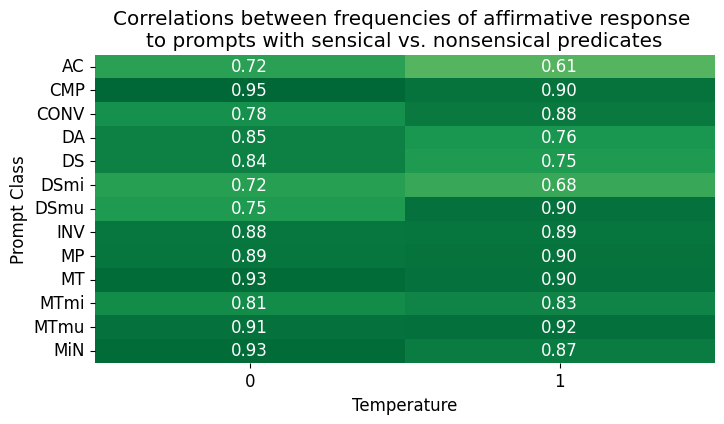

In [42]:
# Extract unique temperatures and prompt classes
unique_temperatures = sorted(set(temp for _, temp in correlation_across_models_by_temp.keys()))
unique_prompt_classes = sorted(set(prompt_class for prompt_class, _ in correlation_across_models_by_temp.keys()))

# Convert the dictionary to a format suitable for a DataFrame
data_for_heatmap = {temp: {prompt_class: correlation_across_models_by_temp.get((prompt_class, temp), None)
                           for prompt_class in unique_prompt_classes}
                    for temp in unique_temperatures}

# Convert to DataFrame and drop rows with all NaN values
correlation_df = pd.DataFrame(data_for_heatmap).dropna(how='all')

# Create the heatmap
plt.figure(figsize=(8, 4))

# Use rc_context to set font size locally
with plt.rc_context({'font.size': 12}):
    sns.heatmap(correlation_df, annot=True, cmap='RdYlGn', center=0, fmt=".2f", cbar=False)
    plt.title("Correlations between frequencies of affirmative response \nto prompts with sensical vs. nonsensical predicates")
    plt.ylabel("Prompt Class")
    plt.xlabel("Temperature")

    # Save the plot as a PDF file with a tight layout
    plt.savefig(f'results/{condition}/correlations_{condition}.pdf', bbox_inches='tight')
    
plt.show()

## 5.3 Correlations between different question wordings

In [43]:
def yes_correlation(prompt_class1,prompt_class2):

    prompt_class1_freq = []
    prompt_class2_freq = []

    for model in df['model'].unique():
        for temp in df['temperature'].unique():
            prompt_class1_mean = df[(df['prompt_class'] == prompt_class1) & (df['model'] == model) & (df['temperature'] == temp)]['yes_percent'].mean()
            prompt_class2_mean = df[(df['prompt_class'] == prompt_class2) & (df['model'] == model) & (df['temperature'] == temp)]['yes_percent'].mean() 

            if np.isnan(prompt_class1_mean):
                print(df[(df['prompt_class'] == prompt_class1) & (df['model'] == model) & (df['temperature'] == temp)]['yes_percent'])

            prompt_class1_freq.append(prompt_class1_mean)
            prompt_class2_freq.append(prompt_class2_mean)

    correlation = pd.Series(prompt_class1_freq).corr(pd.Series(prompt_class2_freq))

    return correlation

In [44]:
# As mentioned in the text, the correlation is very high between responses to 'AC' and responses to variants
# that replace 'infer' with 'conclude', 'deduce', 'logically infer', 'logically conclude', etc.

for prompt in ['cAC', 'dAC', 'gAC', 'gnAC', 'LAC', 'LcAC', 'LdAC', 'sAC', 'snAC']:

    print(f"Correlation between AC and {prompt}: {yes_correlation('AC',prompt)}")

Correlation between AC and cAC: 0.9694384715757152
Correlation between AC and dAC: 0.9827697576206847
Correlation between AC and gAC: 0.9396735158650307
Correlation between AC and gnAC: 0.8876373655104176
Correlation between AC and LAC: 0.9849956536447861
Correlation between AC and LcAC: 0.9701970943987331
Correlation between AC and LdAC: 0.9733199533775965
Correlation between AC and sAC: 0.9240986674450213
Correlation between AC and snAC: 0.8235206623382051


In [45]:
# As mentioned in the text, the correlation is somewhat lower between the 'v' versions and regular versions of prompts:

base_prompts = ['MP', 'MT', 'AC', 'DA', 'DS', 'MTmi', 'MTmu', 'DSmi', 'DSmu']

for prompt in base_prompts:
    print(f"Correlation between {prompt} and {prompt}x: {yes_correlation(prompt,prompt+'x')}")
    print(f"Correlation between {prompt} and v{prompt}: {yes_correlation(prompt,'v'+prompt)}")
    print("")

Correlation between MP and MPx: 0.8948308432268965
Correlation between MP and vMP: 0.959950873139795

Correlation between MT and MTx: 0.9174286445411086
Correlation between MT and vMT: 0.6337679258673785

Correlation between AC and ACx: 0.6732690614238138
Correlation between AC and vAC: 0.7750254454533212

Correlation between DA and DAx: 0.8146863584860445
Correlation between DA and vDA: 0.6136486615384661

Correlation between DS and DSx: 0.7378455532591391
Correlation between DS and vDS: 0.7052045298840095

Correlation between MTmi and MTmix: 0.8172536059599235
Correlation between MTmi and vMTmi: 0.4957071291490893

Correlation between MTmu and MTmux: 0.9124861446301431
Correlation between MTmu and vMTmu: 0.5666178449931701

Correlation between DSmi and DSmix: 0.7028649655190964
Correlation between DSmi and vDSmi: 0.3571304164291603

Correlation between DSmu and DSmux: 0.8086534599036724
Correlation between DSmu and vDSmu: 0.6050555458626733



## 5.4 Log Probs

In [46]:
log_prob_condition = f'{condition}_log_probs' # condition cannot be chain-of-thought here
log_prob_temperature = None

### Collect model log probs

In [47]:
get_responses = False

for model_num in model_nums:

    model_short_name = model_dict[model_num][0]
    model_display_name = model_dict[model_num][1]
    model_full_name = model_dict[model_num][2]
    model_lmsys_name = model_dict[model_num][3]
    
    if get_responses:
        print("Model:", model_short_name)
        print("Condition:", log_prob_condition)
        print("")

        for up in tqdm(user_prompts):

                prompt_class, prompt_num, user_prompt = up

                if condition == 'few-shot' and prompt_class in ['LAC','cAC','LcAC','dAC','LdAC','sAC','snAC','gAC','gnAC']:
                        continue

                # if the data file already exists, continue
                if os.path.exists(f'data/{log_prob_condition}/{model_short_name}/{prompt_class}/{model_short_name}_{prompt_class}_{prompt_num}_{log_prob_temperature}.json'):
                        continue

                print("Prompt:", user_prompt)
                print("")

                data = {
                        "user_prompt": user_prompt,
                        "system_prompt": system_prompt,
                        "model": model_full_name,
                        "yes_prob": None,
                        "no_prob": None,
                        }

                if model_short_name in ['gpt_4o_2024_05_13','gpt_4_turbo_2024_04_09', 'gpt_4_turbo_1106', 'gpt_4_0613', 'gpt_4_0314', 'gpt_3_5_turbo_1106', 'gpt_3_5_turbo_0613', 'gpt_3_5_turbo_0125']:

                        client = OpenAI(api_key=OPENAI_API_KEY)
                        completion = client.chat.completions.create(
                        model=model_full_name,
                        logprobs=True,
                        top_logprobs=20,
                        messages=[
                                {"role": "system", "content": system_prompt},
                                {"role": "user", "content": user_prompt}],
                        max_tokens=max_tokens,
                        )

                        logprobs = completion.choices[0].logprobs.content[0].top_logprobs

                        yes_prob = None
                        no_prob = None

                        for logprob in logprobs:

                                if (logprob.token == "yes" or logprob.token == "Yes") and yes_prob == None:
                                        yes_prob = np.exp(logprob.logprob)*100

                                if (logprob.token == "no" or logprob.token == "No") and no_prob == None:
                                        no_prob = np.exp(logprob.logprob)*100
                        
                        if yes_prob == None and no_prob == None:
                                print("Error")
                                print([logprob.token for logprob in logprobs])
                        
                        if yes_prob == None and no_prob != None:
                                yes_prob = 0

                        if no_prob == None and yes_prob != None:
                                no_prob = 0

                        normalized_yes_prob = yes_prob/(yes_prob+no_prob)
                        normalized_no_prob = no_prob/(yes_prob+no_prob)

                        data["yes_prob"] = normalized_yes_prob
                        data["no_prob"] = normalized_no_prob

                        print("Yes:", np.round(normalized_yes_prob,2))
                        print("No:", np.round(normalized_no_prob,2))   

                        print("")
                
                # create the appropriate directory if it doesn't already exist
                if not os.path.exists(f'data/{log_prob_condition}/{model_short_name}/{prompt_class}'):
                        os.makedirs(f'data/{log_prob_condition}/{model_short_name}/{prompt_class}')

                # Save the data to a JSON file
                with open(f'data/{log_prob_condition}/{model_short_name}/{prompt_class}/{model_short_name}_{prompt_class}_{prompt_num}_{log_prob_temperature}.json', 'w') as json_file:
                        json.dump(data, json_file, indent=4)

### Create dataframe from log probs

In [48]:
verbose = False # Set to True to print out warnings and errors

models_with_prompts_not_finished = list()

log_prob_df = pd.DataFrame(columns=["prompt_class", "prompt_num", "prompt", "model", "temperature", "yes_percent", "no_percent"])

model_display_names = [model_dict[mod][1] for mod in model_dict.keys()]

for up in tqdm(user_prompts):

    prompt_class, prompt_num, user_prompt = up

    if log_prob_condition == 'few-shot' and prompt_class in ['LAC','cAC','LcAC','dAC','LdAC','sAC','snAC','gAC','gnAC']:
        continue

    for mod in model_dict.keys():

        model_short_name = model_dict[mod][0]
        model_display_name = model_dict[mod][1]

        if not model_short_name in ['gpt_3_5_turbo_0125', 'gpt_3_5_turbo_0613', 'gpt_3_5_turbo_1106', 'gpt_4_0314', 'gpt_4_0613', 'gpt_4_turbo_1106', 'gpt_4_turbo_2024_04_09', 'gpt_4o_2024_05_13']:
            continue


        # if the data file does not exist, continue

        if not os.path.exists(f'data/{log_prob_condition}/{model_short_name}/{prompt_class}/{model_short_name}_{prompt_class}_{prompt_num}_{log_prob_temperature}.json'):
            
            if (model_display_name, prompt_class) not in models_with_prompts_not_finished:
                models_with_prompts_not_finished.append((model_display_name, prompt_class))

            if verbose == True:
                print(f'data/{log_prob_condition}/{model_short_name}/{prompt_class}/{model_short_name}_{prompt_class}_{prompt_num}_{log_prob_temperature}.json does not exist')
            
            continue

        with open(f'data/{log_prob_condition}/{model_short_name}/{prompt_class}/{model_short_name}_{prompt_class}_{prompt_num}_{log_prob_temperature}.json', 'r') as json_file:
            data = json.load(json_file)
                        
            # append the data to the dataframe
            new_row = {"prompt_class": prompt_class, 
                        "prompt_num": prompt_num, 
                        "prompt": user_prompt, 
                        "model": model_display_name, 
                        "temperature": log_prob_temperature,
                        "yes_percent": data["yes_prob"], 
                        "no_percent": data["no_prob"]
                        }
            
            new_row_df = pd.DataFrame([new_row])
            log_prob_df = pd.concat([log_prob_df, new_row_df], ignore_index=True)

if not os.path.exists(f'results/{log_prob_condition}'):
    os.makedirs(f'results/{log_prob_condition}')

# save the dataframe to a csv file
log_prob_df.to_csv(f"results/{log_prob_condition}/results_{log_prob_condition}.csv")

# save the dataframe as a json file
log_prob_df.to_json(f"results/{log_prob_condition}/results_{log_prob_condition}.json", orient="records")

print("")

log_prob_df

100%|██████████| 2080/2080 [00:10<00:00, 204.28it/s]


,prompt_class,prompt_num,prompt,model,temperature,yes_percent,no_percent
0,DSx,1,From 'Either the flugel is blimmed or it is za...,GPT-3.5 Turbo (0613),None,0.603923,3.960773e-01
1,DSx,1,From 'Either the flugel is blimmed or it is za...,GPT-3.5 Turbo (1106),None,0.918715,8.128499e-02
2,DSx,1,From 'Either the flugel is blimmed or it is za...,GPT-3.5 Turbo (0125),None,0.900835,9.916533e-02
3,DSx,1,From 'Either the flugel is blimmed or it is za...,GPT-4 (0314),None,0.999999,7.469566e-07
4,DSx,1,From 'Either the flugel is blimmed or it is za...,GPT-4 (0613),None,1.000000,5.419813e-08
...,...,...,...,...,...,...,...
16635,DSmu,20,From 'Either the sunglasses are in her bag or ...,GPT-4 (0314),None,0.999997,3.478887e-06
16636,DSmu,20,From 'Either the sunglasses are in her bag or ...,GPT-4 (0613),None,0.999999,5.632696e-07
16637,DSmu,20,From 'Either the sunglasses are in her bag or ...,GPT-4 Turbo (1106),None,0.999848,1.515323e-04
16638,DSmu,20,From 'Either the sunglasses are in her bag or ...,GPT-4 Turbo (2024-04-09),None,1.000000,1.692766e-07


In [49]:
# Filter df for temperature 1
df_temp_1 = df[df['temperature'] == 1]

# Merge the filtered df_temp_1 with log_prob_df on 'prompt_class', 'prompt_num', and 'model'
merged_df = pd.merge(df_temp_1, log_prob_df, on=['prompt_class', 'prompt_num', 'model'], suffixes=('_df', '_log_prob_df'))

# Calculate the correlation between 'yes_percent_df' and 'yes_percent_log_prob_df'
correlation = merged_df['yes_percent_df'].corr(merged_df['yes_percent_log_prob_df'])

print(f'The correlation between the frequentist and log-prob-based yes_percent values is: {correlation}')

The correlation between the frequentist and log-prob-based yes_percent values is: 0.9769544585522363


Unique temperatures found in the DataFrame: [None]
Processing temperature: None


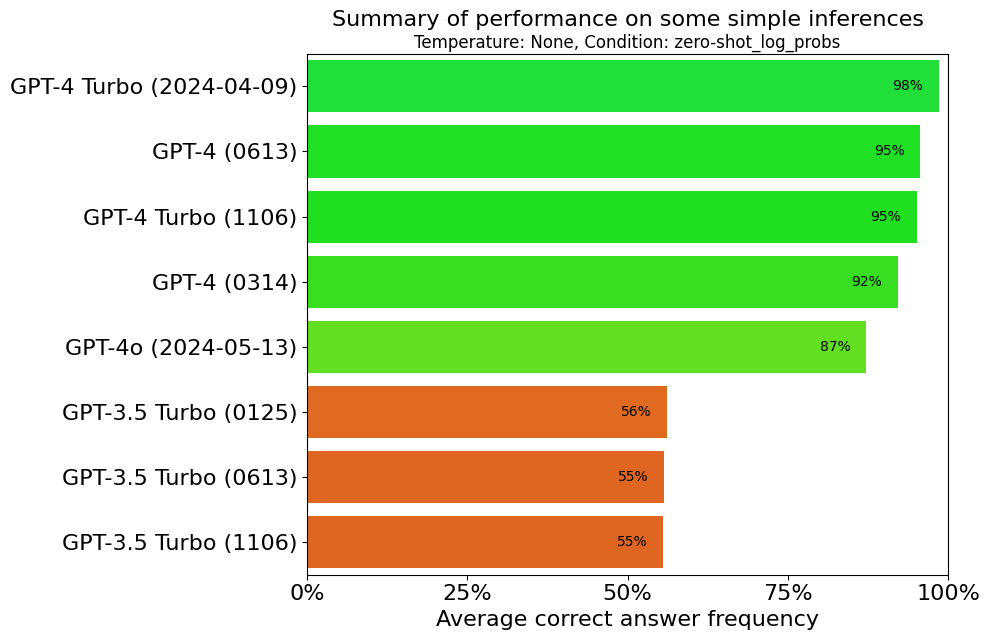

In [50]:
create_performance_summary(log_prob_df, log_prob_condition, models_not_finished, correct_answers)